# **LAB 01: Thu nhập dữ liệu và trực quan hóa dữ liệu**

---
### **Thông tin thành viên**

|   MSSV   |  Họ và tên  |
|:--------:|:-----------:|
| 22127117 | Lý Liên Hoa |
| 22127352 | Võ Anh Quân |

---

## **Tóm tắt đồ án**

Hiện nay, các nền tảng nghe nhạc trực tuyến như Spotify, Zing MP3, Nhaccuatui, SoundCloud, ... là một trong
những kênh để nghe nhạc và khám phá các xu hướng âm nhạc mới. Trên các nền tảng này chứa dữ liệu khổng
lồ về các thông tin bài hát, nghệ sĩ, thể loại.  

Ở đò án này, nhóm chúng em chọn thu thập dữ liệu và thực hiện việc phân tích dữ liệu về thống kê, xu hướng âm nhạc của người dùng hiện này trên một trong những trang web âm nhạc trực tuyến lớn nhất Việt Nam - **Zing MP3**.    

Với trong [QUYỀN HẠN](https://zingmp3.vn/robots.txt) cho phép, việc thu thập dữ liệu sẽ được thực hiện trên trang Zing MP3, nơi có các album xếp hạng Top 100 bài hát hay ở mỗi thể loại hiện nay, thông qua việc sử dụng công cụ **Selenium**. Sau khi hoàn thành tất việc thu thập dữ liệu, nhóm chúng em thu có tổng cộng **3506 records** và **8 thuộc tính** (bao gồm "Album".	"Tên bài hát", "Lượt yêu thích", "Lượt nghe", "Nghệ sĩ", "Sáng tác", "Thể loại", "Nhà cung cấp")

*(Dữ liệu được cập nhật lần cuối vào 19/02/2025)*

---

## **Phần 1: Thu thập dữ liệu**

### **Thư viện**

In [2]:
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### **1. Hàm lấy thông tin các bài hát có trong một album**

In [ ]:
def init_driver():
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--start-maximized")  # Bật full màn hình
    driver = webdriver.Chrome(options=chrome_options)
    return driver
    

def close_popup(driver):
    try:
        close_button = WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.CLASS_NAME, "close-btn")))
        close_button.click()
        print("--> Popup đã đóng!")
        time.sleep(1)
    except:
        print("--> Không có popup!")

In [ ]:
def get_song_info_from_portal(portal_element):
    # Tên bài hát
    try:
        song_title = portal_element.find_element(By.CLASS_NAME, "item-title").text
    except:
        song_title = None
    # Lượt thích
    try:
        likes = portal_element.find_element(By.XPATH, "//div[@class='stat-item']/i[contains(@class, 'ic-like')]/following-sibling::span").text
    except:
        likes = None
    # Lượt nghe
    try:
        views = portal_element.find_element(By.XPATH, "//div[@class='stat-item']/i[contains(@class, 'ic-view')]/following-sibling::span").text
    except:
        views = None
        
    return song_title, likes, views

In [ ]:
def extract_info_from_submenu(submenu, label):
    try:
        return submenu.find_element(By.XPATH, f".//h3[contains(text(), '{label}')]/following-sibling::div").text
    except:
        return None
    
def get_submenu_info(driver, portal_element):
    actions = ActionChains(driver)
    try:
        song_image = portal_element.find_element(By.TAG_NAME, "img")  # Tìm hình ảnh xuất hiện trên portal
        actions.move_to_element(song_image).perform()  # Di chuyển chuột tới hình ảnh đó
        time.sleep(2)  

        submenu = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CLASS_NAME, "submenu-content"))
        )

        artist = extract_info_from_submenu(submenu, "Nghệ sĩ")
        album = extract_info_from_submenu(submenu, "Album")
        composer = extract_info_from_submenu(submenu, "Sáng tác")
        genre = extract_info_from_submenu(submenu, "Thể loại")
        provided_by = extract_info_from_submenu(submenu, "Cung cấp bởi")

    except:
        print(f"Không thể hover vào hình ảnh bài hát.")
        artist, album, composer, genre, provided_by = None, None, None, None, None

    return artist, album, composer, genre, provided_by

##### Hàm chính lấy thông tin các bài hát trong album

In [ ]:
def get_info_songs_album(driver, url, album_title):
    print(f"\n => Đang thu thập dữ liệu từ album: {album_title} | URL: {url}")

    # TRUY CẬP TRANG WEB CỦA ALBUM
    driver.get(url)
    time.sleep(5)
    
    # ĐÓNG POPUP (NẾU CÓ)
    close_popup(driver)
    
    # TÌM DANH SÁCH CÁC BÀI HÁT
    songs = driver.find_elements(By.CLASS_NAME, "media-left")[2:]
    song_data = []

    # LẤY THÔNG TIN CỦA TỪNG BÀI HÁT
    for index, song in enumerate(songs):  
        try:
            # 1. Click chuột phải vào tên Album của bài hát để mở menu ngữ cảnh (có chứa các thông tin về bài hát)
            actions = ActionChains(driver)
            actions.context_click(song).perform()
            time.sleep(2)

            # 2. Sau khi click chuột phải, tìm portal xuất hiện trên web
            portal_element = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CLASS_NAME, "zm-portal"))
            )

            # 3. Lấy thông tin bài hát từ portal đó
            song_title, likes, views = get_song_info_from_portal(portal_element)

            # 4. Hover chuột vào hình ảnh để hiển thị submenu-content trên web
            artist, album, composer, genre, provided_by = get_submenu_info(driver, portal_element)

            # 5. Lưu vào danh sách
            song_data.append({
                "Tên bài hát": song_title,
                "Album": album,
                "Lượt yêu thích": likes,
                "Lượt nghe": views,
                "Nghệ sĩ": artist,
                "Sáng tác": composer,
                "Thể loại": genre,
                "Nhà cung cấp": provided_by
            })

            print(f"{index+1}. {song_title} | {artist} | {album} | {composer} | {genre} | {provided_by} | {likes} | {views}")

            # Đóng portal hiện tại để tránh lỗi khi click bài tiếp theo
            driver.execute_script("document.querySelector('.zm-portal').remove();")

        except Exception as e:
            print(f"Lỗi khi lấy bài hát {index}: {e}")

    return song_data

### **2. Hàm lấy tất cả bài hát có trong tất cả album**

In [ ]:
def wait_album_list(driver):
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//h4[@class='title is-6']/a"))
        )
        print("Danh sách album đã xuất hiện!")
    except:
        print("Không tìm thấy danh sách album. Kiểm tra lại XPath hoặc chờ tải trang lâu hơn.")
        driver.quit()
        return False
    
    return True

In [ ]:
def get_albums_at_present(driver, album_links, seen_albums):
    albums = driver.find_elements(By.XPATH, "//h4[@class='title is-6']/a")
    new_count = 0

    for album in albums:
        try:
            album_title = album.get_attribute("title").strip()
            album_url = album.get_attribute("href").strip()

            if album_url not in seen_albums:
                album_links.append((album_title, album_url))
                seen_albums.add(album_url)
                new_count += 1
        except:
            continue

    return new_count

def collect_albums(driver):
    album_links = []  # Dùng list để lưu theo thứ tự
    seen_albums = set()  # Dùng set để tránh trùng lặp

    while True:
        new_albums = get_albums_at_present(driver, album_links, seen_albums)
        if new_albums == 0:  # Nếu không có album mới, dừng lại
            break
        driver.execute_script("window.scrollBy(0, 600);")  # Cuộn xuống một chút
        time.sleep(1)

    print(f"Tổng số album tìm thấy: {len(album_links)}")
    
    return album_links

In [ ]:
def crawling_songs():
    print("\nBắt đầu thu thập dữ liệu ...")
    driver = init_driver()

    # TRUY CẬP TRANG WEB CHỨA CÁC ALBUM TOP 100
    top100_url = "https://zingmp3.vn/top100"
    driver.get(top100_url)
    time.sleep(5)  # Chờ trang tải

    # ĐÓNG POPUP (NẾU CÓ)
    close_popup(driver)

    # 1. Chờ danh sách các album xuất hiện trên web
    if not wait_album_list(driver):
        return

    # 2. Lấy tất cả album có mặt trên web trước khi cuộn xuống lấy tiếp
    album_links = collect_albums(driver)

    if len(album_links) == 0: # Không có album
        print("Không tìm thấy album nào :(")
        return

    # 3. Lưu dữ liệu bài hát từ tất cả album
    all_song_data = []

    # 4. Duyệt qua từng album để lấy danh sách bài hát theo thứ tự
    for album_title, album_url in album_links:
        song_data = get_info_songs_album(driver, album_url, album_title)
        all_song_data.extend(song_data)

    # Đóng trình duyệt
    driver.quit()

    # 5. Lưu tất cả bài hát vào file csv
    df = pd.DataFrame(all_song_data)
    
    csv_filename = "songs_df.csv"
    df.to_csv(csv_filename, index=False, encoding="utf-8-sig")

    print(f"\n Dữ liệu từ tất cả album Top 100 đã được lưu vào tệp: {csv_filename}")

    return df


#### **Bắt đầu thu thập dữ liệu**

In [ ]:
crawling_songs()

## **Phần 2: Khám phá, phân tích và tiền xử lý dữ liệu**

### **1. Khám phá dữ liệu**

#### **Thiết lập tùy chọn hiển thị**

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

#### **Đọc dữ liệu**

In [4]:
df = pd.read_csv('./Data/songs_df.csv')

df.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp
0,Mất Kết Nối,Dữ Liệu Quý (EP),582K,23.6M,Dương Domic,Dương Domic,"Việt Nam, V-Pop",DAO Music Entertainment
1,Tái Sinh,MULTIVERSE,744K,24.1M,Tùng Dương,Tăng Duy Tân,"Việt Nam, V-Pop",+84 Vietnam New Wave
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,"Việt Nam, V-Pop",MIXUS
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501K,18.1M,Trần Mạnh Cường,Trần Mạnh Cường,"Việt Nam, V-Pop",Incom
4,Cảm Ơn Em,Cảm Ơn Em (Single),279K,10M,Đặng Thiên Chí,Đặng Thiên Chí,"Việt Nam, V-Pop",VIEENT Music
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103K,2.8M,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân","Việt Nam, V-Pop",Euphoria Media Vietnam
6,E Là Không Thể,E Là Không Thể (Single),398K,16.2M,Anh Quân,Đông Thiên Đức,"Việt Nam, V-Pop",DAO Music Entertainment
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,"Việt Nam, V-Pop",Euphoria Media Vietnam
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,"Việt Nam, V-Pop",TECHBEAT Music
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,"Việt Nam, V-Pop",MIXUS


#### **Kích thước dữ liệu**

In [5]:
df.size

28768

#### **Hình dạng dữ liệu**

In [6]:
n_rows, n_cols = df.shape

print(f"Số lượng dòng: {n_rows}")
print(f"Số lượng cột: {n_cols}")

Số lượng dòng: 3596
Số lượng cột: 8


#### **Thông tin cơ bản**

- **Ý nghĩa của mỗi dòng dữ liệu**:  Mỗi dòng trong tập dữ liệu là thông tin cơ bản của một bài hát cụ thể như tên bài hát, nghệ sĩ, sáng tác, ...

- **Ý nghĩa của mỗi cột dữ liệu**: 

| Thuộc tính     | Ý nghĩa                                                                           |
|----------------|----------------------------------------------------------------------------------:|
| Album          | Tên album mà bài hát thuộc về (nếu có). Một số bài hát có thể là Single (Đĩa đơn) |
| Tên bài hát    | Tên của bài hát                                                                   |
| Lượt yêu thích | Tổng số lượng người yêu thích bài hát                                             |
| Lượt nghe      | Tổng số lượt nghe bài hát                                                         |
| Nghệ sĩ        | Tên của (các) ca sĩ hoặc nhóm nhạc trình bày bài hát                              |
| Sáng tác       | Tên của nhạc sĩ hoặc nhóm viết bài hát                                            |
| Thể loại       | Thể loại âm nhạc của bài hát                                                      |
| Nhà cung cấp   | Công ty hoặc đơn vị, cá nhân phát hành và phân phối bài hát trên nền tảng nhạc    |

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3596 entries, 0 to 3595
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tên bài hát     3596 non-null   object
 1   Album           3340 non-null   object
 2   Lượt yêu thích  1150 non-null   object
 3   Lượt nghe       1150 non-null   object
 4   Nghệ sĩ         3576 non-null   object
 5   Sáng tác        2654 non-null   object
 6   Thể loại        3521 non-null   object
 7   Nhà cung cấp    3581 non-null   object
dtypes: object(8)
memory usage: 224.9+ KB


### **2. Tiền xử lý và phân tích dữ liệu**

#### **Kiểm tra có dòng nào bị lặp lại không?**

In [8]:
duplicated_rows = df.duplicated().sum()

print(f"--> Tổng số dòng bị lặp: {duplicated_rows}")

--> Tổng số dòng bị lặp: 192


- Xóa tất cả dòng bị lặp giữ nguyên dòng đầu tiên

In [9]:
df_cleaned = df.drop_duplicates(keep='first')

print(f"--> Hình dạng tập dữ liệu sau khi loại bỏ trùng lập: {df_cleaned.shape}")

--> Hình dạng tập dữ liệu sau khi loại bỏ trùng lập: (3404, 8)


#### **Kiểm tra kiểu dữ liệu của từng cột có thích hợp không?**

In [10]:
df_cleaned.dtypes

Tên bài hát       object
Album             object
Lượt yêu thích    object
Lượt nghe         object
Nghệ sĩ           object
Sáng tác          object
Thể loại          object
Nhà cung cấp      object
dtype: object

- `Lượt yêu thích` và `Lượt nghe` được lưu dươi dạng đơn vị 'K' (nếu giá trị nằm trong khoảng $1000 - 999,999$), 'M' (nếu giá trị nằm trong khoảng $1$ triệu đổ lên), và không có đơn vị (nếu giá trị nhỏ hơn $1000$).

$\rightarrow$ Chuyển đổi sang dạng numeric bằng cách lấy giá trị trước 'K' và 'M', lần lượt nhân với $1,000$ (đối với 'K') và $1,000,000$ (đối với 'M').

In [11]:
def convert_to_numeric(str_val):
    if str_val is None or str_val == 'NaN':
        return None
    
    if isinstance(str_val, str):
        val = float(str_val.strip('K, M'))
        
        if 'K' in str_val:
            return val * 1000
        elif 'M' in str_val:
            return val * 1e6
    
    return str_val

In [12]:
df_cleaned = df_cleaned.copy()

In [13]:
df_cleaned.loc[:, 'Lượt yêu thích (dễ nhìn)'] = df_cleaned['Lượt yêu thích']
df_cleaned.loc[:, 'Lượt nghe (dễ nhìn)'] = df_cleaned['Lượt nghe']

In [14]:
df_cleaned.loc[:, 'Lượt yêu thích'] = df_cleaned['Lượt yêu thích (dễ nhìn)'].apply(convert_to_numeric)
df_cleaned.loc[:, 'Lượt nghe'] = df_cleaned['Lượt nghe (dễ nhìn)'].apply(convert_to_numeric)

df_cleaned['Lượt yêu thích'] = df_cleaned['Lượt yêu thích'].astype('float64')
df_cleaned['Lượt nghe'] = df_cleaned['Lượt nghe'].astype('float64')

df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn)
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,"Việt Nam, V-Pop",DAO Music Entertainment,582K,23.6M
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,"Việt Nam, V-Pop",+84 Vietnam New Wave,744K,24.1M
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,"Việt Nam, V-Pop",MIXUS,NaN,NaN
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,"Việt Nam, V-Pop",Incom,501K,18.1M
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,"Việt Nam, V-Pop",VIEENT Music,279K,10M
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân","Việt Nam, V-Pop",Euphoria Media Vietnam,103K,2.8M
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,"Việt Nam, V-Pop",DAO Music Entertainment,398K,16.2M
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,"Việt Nam, V-Pop",Euphoria Media Vietnam,NaN,NaN
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,"Việt Nam, V-Pop",TECHBEAT Music,NaN,NaN
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,"Việt Nam, V-Pop",MIXUS,NaN,NaN


In [15]:
print("--> Kiểu dữ liệu sau khi chuyển đổi:")
df_cleaned.dtypes

--> Kiểu dữ liệu sau khi chuyển đổi:


Tên bài hát                  object
Album                        object
Lượt yêu thích              float64
Lượt nghe                   float64
Nghệ sĩ                      object
Sáng tác                     object
Thể loại                     object
Nhà cung cấp                 object
Lượt yêu thích (dễ nhìn)     object
Lượt nghe (dễ nhìn)          object
dtype: object

- Thống kê cơ bản của kiểu dữ liệu số

In [16]:
df_cleaned.describe(include=[np.number]).apply(lambda s: s.apply('{:,.0f}'.format))

,Lượt yêu thích,Lượt nghe
count,"1,068","1,068"
mean,"64,995","4,246,475"
std,"226,922","14,956,190"
min,3,279
25%,383,"26,750"
50%,"2,000","330,000"
75%,"26,250","1,725,000"
max,"2,800,000","190,000,000"


$\rightarrow$ Phân phối có xu hướng lệch phải (mean > median)

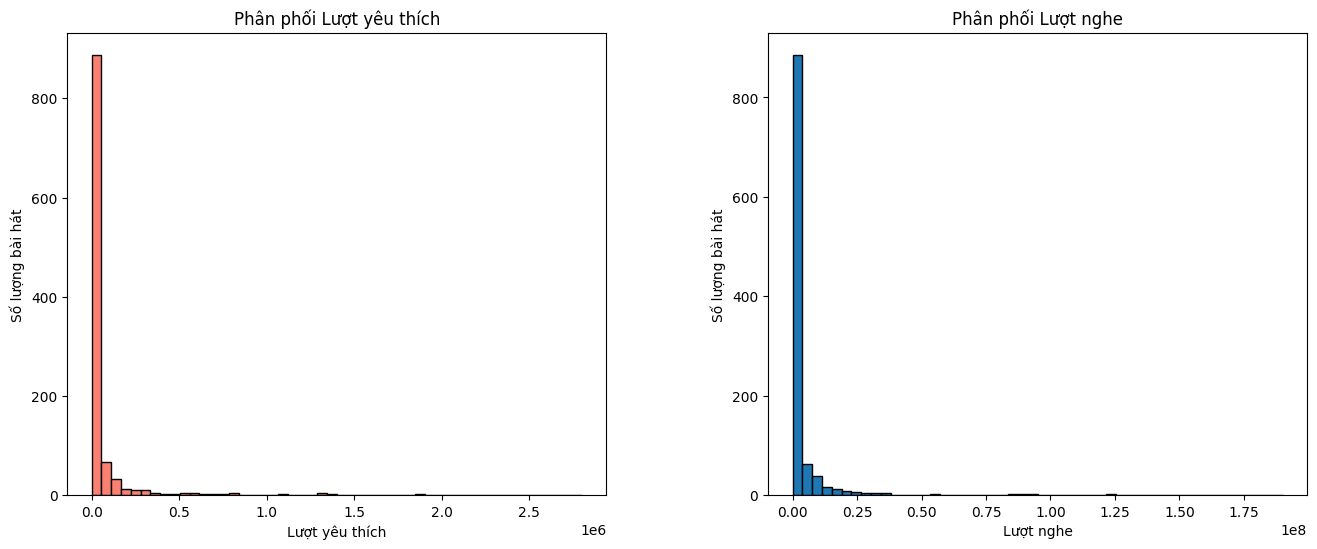

In [17]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.hist(df_cleaned['Lượt yêu thích'].dropna(), color='salmon', bins=50, edgecolor='black')
plt.title("Phân phối Lượt yêu thích")
plt.xlabel('Lượt yêu thích')
plt.ylabel('Số lượng bài hát')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.hist(df_cleaned['Lượt nghe'].dropna(), bins=50, edgecolor='black')
plt.title("Phân phối Lượt nghe")
plt.xlabel('Lượt nghe')
plt.ylabel('Số lượng bài hát')

plt.subplots_adjust(wspace=0.3)
plt.show()


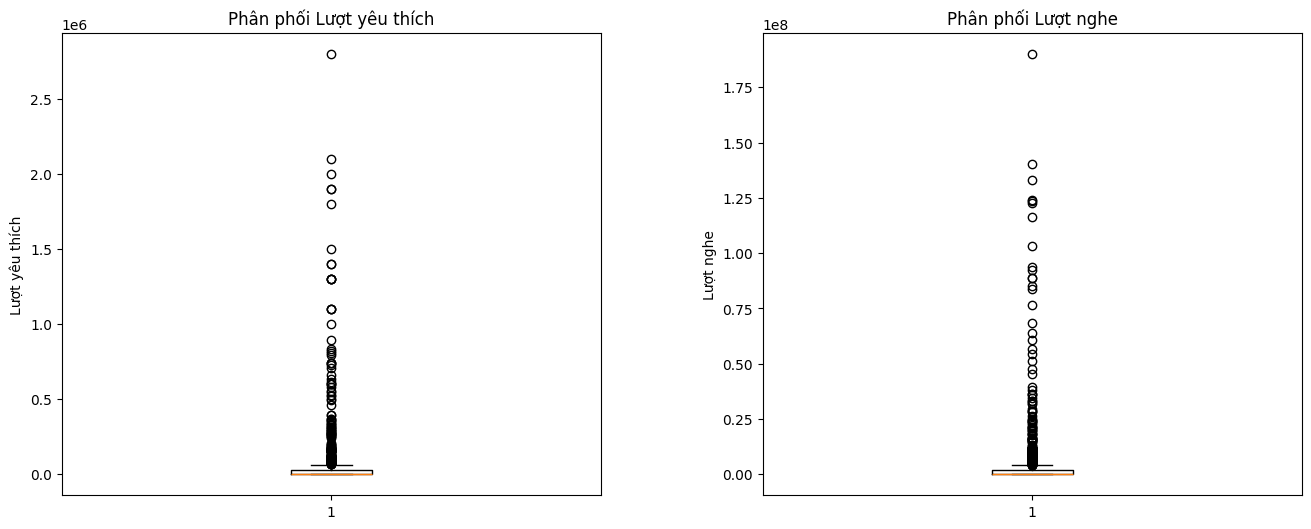

In [18]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'].dropna())
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'].dropna())
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


$\rightarrow$ Tồn tại rất nhiều giá trị ngoại lai

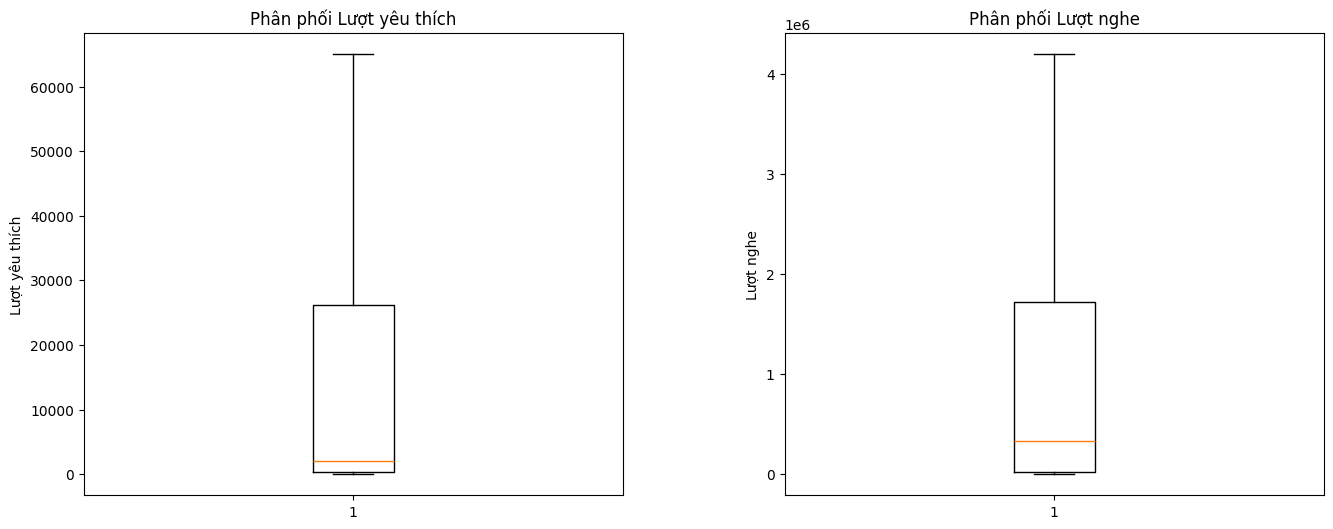

In [19]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'].dropna(), showfliers=False)
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'].dropna(), showfliers=False)
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


#### **Tách giá trị ở cột `Thể loại` thành 2 cột chứa 'thể loại' và 'quốc gia, châu lục' riêng biệt**

In [20]:
theloai_df = df_cleaned['Thể loại'] 

theloai_df.head()

0    Việt Nam, V-Pop
1    Việt Nam, V-Pop
2    Việt Nam, V-Pop
3    Việt Nam, V-Pop
4    Việt Nam, V-Pop
Name: Thể loại, dtype: object

- Kiểm tra xem trước dấu phẩy của cột `Thể loại` có phải hoàn toàn là cụ thể một quốc gia, châu lục nào đó không?

In [21]:
theloai_df.str.split(',').str[0].unique()

array(['Việt Nam', 'V-Pop', nan, 'Âu Mỹ', 'Pop', 'Hàn Quốc', 'Rap Việt',
       'Nhạc Trữ Tình', 'Hòa Tấu', 'Hoa Ngữ', 'Nhạc Phim', 'Nhạc Trịnh',
       'Nhạc Không Lời', 'Nhạc Thiếu Nhi', 'Dance Việt', 'Rock Việt',
       'Nhật Bản', 'Khác', 'Saxophone', 'Classical'], dtype=object)

$\rightarrow$ Các quốc gia có thể là: **Việt Nam, Âu Mỹ, Hàn Quốc, Trung Quốc, Nhật Bản**. Còn lại là thuộc phần thể loại.

Trong ngữ cảnh này, các giá trị như V-Pop, Rap Việt, Nhạc Trữ Tình, Nhạc Trịnh, Dance Việt, Rock Việt là của **Việt Nam**.

In [22]:
countries_list = ['Việt Nam', 'Âu Mỹ', 'Hàn Quốc', 'Nhật Bản']
vn_list = ['V-Pop', 'Rap Việt', 'Nhạc Trữ Tình', 'Nhạc Trịnh', 'Dance Việt', 'Rock Việt']

def process_type_col_country(str_val):
    if isinstance(str_val, str):
        for country in countries_list:
            if country in str_val:
                return country

        for genre in vn_list:
            if genre in str_val:
                return 'Việt Nam'

    return None
    
def process_type_col_type(str_val):
    if isinstance(str_val, str):
        for country in countries_list:
            if country in str_val:
                str_val = str_val.replace(country, '').strip(', ').strip()

        str_val = re.sub(r',\s*,', ',', str_val)  # Thay thế nhiều dấu phẩy bằng một
        
        return str_val if str_val else 'Không rõ'
    else:
        return None

In [23]:
df_cleaned['Thể loại'] = theloai_df.apply(process_type_col_type)
df_cleaned['Quốc gia'] = theloai_df.apply(process_type_col_country)

df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn),Quốc gia
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,V-Pop,DAO Music Entertainment,582K,23.6M,Việt Nam
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,V-Pop,+84 Vietnam New Wave,744K,24.1M,Việt Nam
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,V-Pop,MIXUS,NaN,NaN,Việt Nam
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,V-Pop,Incom,501K,18.1M,Việt Nam
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,V-Pop,VIEENT Music,279K,10M,Việt Nam
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân",V-Pop,Euphoria Media Vietnam,103K,2.8M,Việt Nam
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,V-Pop,DAO Music Entertainment,398K,16.2M,Việt Nam
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,V-Pop,Euphoria Media Vietnam,NaN,NaN,Việt Nam
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,V-Pop,TECHBEAT Music,NaN,NaN,Việt Nam
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,V-Pop,MIXUS,NaN,NaN,Việt Nam


#### **Kiểm tra cột có dữ liệu bị thiếu không?**

In [24]:
missing_df = df_cleaned.isnull().sum()

print("Tổng dữ liệu bị thiếu ở mỗi cột")
missing_df

Tổng dữ liệu bị thiếu ở mỗi cột


Tên bài hát                    0
Album                        246
Lượt yêu thích              2336
Lượt nghe                   2336
Nghệ sĩ                       20
Sáng tác                     905
Thể loại                      75
Nhà cung cấp                  15
Lượt yêu thích (dễ nhìn)    2336
Lượt nghe (dễ nhìn)         2336
Quốc gia                     672
dtype: int64

- Cách thức xử lý dữ liệu thiếu:
    - Đối với cột `Album`, điền tên bài hát vào vì nếu để ý, ở nhiều bài hát có tên album khá giống với tên bài hát.
    - Cột `Nghệ sĩ` sẽ điền *'Không rõ'*.
    - Ở cột `Lượt yêu thích` và `Lượt nghe` sẽ lấy *mean* để điền vào chỗ missing. Sau đó điền vào cột `Lượt yêu thích (dễ nhìn)`, và `Lượt nghe (dễ nhìn)`
    - Dữ liệu được thu thập vào thời điểm năm 2025, là thời điểm cũng có nhiều ca sĩ kiêm nhạc sĩ, thế nên đối với dữ liệu bị thiếu ở cột `Sáng tác`, CÓ THỂ được điền tên của nghệ sĩ xuất hiện đầu tiên trong cột `Nghệ sĩ`.
    - Tương tự, cũng có nhiều nghệ sĩ tự phát hành âm nhạc của mình, cũng thực hiện việc xử lý dữ liệu thiêu ở cột `Nhà cung cấp` bằng cách *'Cá nhân'*.
    - Còn lại, đối với cột `Thể loại chính`, `Quốc gia`, vì dữ liệu được thu thập theo thứ tự từng album, nên các bài hát thường sẽ có thể loại tương tự nhau. Thế nên, dữ liệu sẽ được điền dựa trên bài hát trước đó.
    - Cột `Thể loại` sẽ được điền giống với cột `Thể loại chính`.

-  Xử lý dữ liệu thiếu ở cột `Album`: 

In [25]:
df_cleaned['Album'] = df_cleaned['Album'].fillna(df_cleaned['Tên bài hát'])

In [26]:
print(f"Tổng dữ liệu sau khi xử lý ở cột 'Album': {df_cleaned['Album'].isnull().sum()}")

Tổng dữ liệu sau khi xử lý ở cột 'Album': 0


-  Xử lý dữ liệu thiếu ở cột `Nghệ sĩ`: 

In [27]:
df_cleaned['Nghệ sĩ'] = df_cleaned['Nghệ sĩ'].fillna('Không rõ')

In [28]:
print(f"Tổng dữ liệu sau khi xử lý ở cột 'Nghệ sĩ': {df_cleaned['Nghệ sĩ'].isnull().sum()}")

Tổng dữ liệu sau khi xử lý ở cột 'Nghệ sĩ': 0


- Xử lý dữ liệu ở cột `Lượt yêu thích`, `Lượt nghe`, `Lượt yêu thích (dễ nhìn)`, và `Lượt nghe (dễ nhìn)`

In [29]:
print(df_cleaned['Thể loại'].unique().tolist())

['V-Pop', 'Dance Việt', 'Rap Việt', 'Nhạc Phim, V-Pop', 'EDM Việt', 'R&B Việt', None, 'Pop', 'Pop, R&B / Soul', 'Pop, Electronic / Dance', 'Electronic / Dance, Pop', 'Alternative, Pop', 'Pop, Rap / Hip Hop', 'Pop, Nhạc Phim', 'Không rõ', 'Pop/Pop Ballad', 'Dance Pop', 'Rap / Hip Hop', 'Nhạc Phim', 'Rap Việt, R&B Việt', 'Electronic / Dance', 'Electronic / Dance, Trance / House / Techno', 'Nhạc Trữ Tình', 'Nhạc Trữ Tình, Nhạc Dân Ca - Quê Hương', 'V-Pop, Nhạc Trữ Tình', 'Hòa Tấu, Piano', 'Hòa Tấu, Guitar', 'Hòa Tấu, Guitar, Saxophone', 'Blues / Jazz', 'Folk', 'R&B / Soul', 'Rap / Hip Hop, R&B / Soul', 'R&B / Soul, Rap / Hip Hop', 'R&B / Soul, Pop', 'Folk, R&B / Soul', 'Hòa Tấu, Classical', 'Hòa Tấu', 'Classical', 'Hoa Ngữ', 'V-Pop, EDM Việt', 'V-Pop, Nhạc Phim', 'Rap Việt, Nhạc Phim', 'Rock Việt, Nhạc Phim', 'Nhạc Phim, Dance Việt', 'Nhạc Trịnh', 'Nhạc Trữ Tình, Nhạc Trịnh, Tết', 'Nhạc Trữ Tình, Nhạc Trịnh', 'Cải Lương', 'Nhạc Không Lời', 'Nhạc Không Lời, EDM Việt', 'Nhạc Thiếu Nhi', 'Nh

Vì ở cột `Thể loại` có nhiều thể loại và tập thể loại khác nhau, nên để thuận tiện cho việc lấy median, thêm cột mới có tên `Thể loại chính` dựa trên [10 thể loại nhạc phổ biến hiện nay](https://antuan.vn/top-10-the-loai-nhac-pho-bien-hien-nay/) và một số loại nhạc phổ biến ở Việt Nam và các nước Đông Nam Á như Nhạc Trữ tình, Nhạc Cách Mạng, Nhạc Trịnh, Cải Lương, hay Nhạc Thiếu Nhi, Hòa Tấu, ....

In [30]:
general_music_types = ['Pop', 'Rock', 'Country', 'EDM', 'Jazz', 'Blues', 'Dance', 'Ballad', 'R&B', 'Nhạc Trữ tình', 'Nhạc Cách Mạng', 'Nhạc Trịnh', 'Cải Lương', 'Nhạc Thiếu Nhi', 'Hòa Tấu', 'Nhạc Phim']

In [31]:
def gen_general_music_type(str_val):
    if isinstance(str_val, str):
        music_types = re.split('[,/]', str_val)
        music_types = [type.strip() for type in music_types]
        
        if music_types[0] in general_music_types:
            return music_types[0]
        
        else:
            for type in general_music_types:
                if any(type in music for music in music_types):
                    return type
                
    return 'Khác'

In [32]:
df_cleaned['Thể loại chính'] = df_cleaned['Thể loại'].apply(gen_general_music_type)

df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn),Quốc gia,Thể loại chính
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,V-Pop,DAO Music Entertainment,582K,23.6M,Việt Nam,Pop
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,V-Pop,+84 Vietnam New Wave,744K,24.1M,Việt Nam,Pop
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,V-Pop,MIXUS,NaN,NaN,Việt Nam,Pop
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,V-Pop,Incom,501K,18.1M,Việt Nam,Pop
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,V-Pop,VIEENT Music,279K,10M,Việt Nam,Pop
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân",V-Pop,Euphoria Media Vietnam,103K,2.8M,Việt Nam,Pop
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,V-Pop,DAO Music Entertainment,398K,16.2M,Việt Nam,Pop
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,V-Pop,Euphoria Media Vietnam,NaN,NaN,Việt Nam,Pop
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,V-Pop,TECHBEAT Music,NaN,NaN,Việt Nam,Pop
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,V-Pop,MIXUS,NaN,NaN,Việt Nam,Pop


In [33]:
likes_mean = df_cleaned['Lượt yêu thích'].mean().round()

df_cleaned['Lượt yêu thích'] = df_cleaned['Lượt yêu thích'].fillna(likes_mean)

In [34]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Lượt yêu thích': {df_cleaned['Lượt yêu thích'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Lượt yêu thích': 0


In [35]:
listening_mean = df_cleaned['Lượt nghe'].mean().round()

df_cleaned['Lượt nghe'] = df_cleaned['Lượt nghe'].fillna(listening_mean)

In [36]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Lượt nghe': {df_cleaned['Lượt nghe'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Lượt nghe': 0


In [37]:
def convert_visible_numeric(val):
    if val < 1000:
        return val
    elif 1000 <= val < 1e6:
        return str(val // 1000) + 'K'
    else:
        return str(val // 1e6) + 'M'

In [38]:
df_cleaned['Lượt yêu thích (dễ nhìn)'] = df_cleaned['Lượt yêu thích'].apply(convert_visible_numeric)
df_cleaned['Lượt nghe (dễ nhìn)'] = df_cleaned['Lượt nghe'].apply(convert_visible_numeric)

In [39]:
df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn),Quốc gia,Thể loại chính
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,V-Pop,DAO Music Entertainment,582.0K,23.0M,Việt Nam,Pop
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,V-Pop,+84 Vietnam New Wave,744.0K,24.0M,Việt Nam,Pop
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),64995.0,4246475.0,Thiên Tú,Thiên Tú,V-Pop,MIXUS,64.0K,4.0M,Việt Nam,Pop
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,V-Pop,Incom,501.0K,18.0M,Việt Nam,Pop
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,V-Pop,VIEENT Music,279.0K,10.0M,Việt Nam,Pop
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân",V-Pop,Euphoria Media Vietnam,103.0K,2.0M,Việt Nam,Pop
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,V-Pop,DAO Music Entertainment,398.0K,16.0M,Việt Nam,Pop
7,Thủy Triều,Thủy Triều (Single),64995.0,4246475.0,Quang Hùng MasterD,Quang Hùng MasterD,V-Pop,Euphoria Media Vietnam,64.0K,4.0M,Việt Nam,Pop
8,Cô Phòng,Cô Phòng (EP),64995.0,4246475.0,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,V-Pop,TECHBEAT Music,64.0K,4.0M,Việt Nam,Pop
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),64995.0,4246475.0,Thái Học,Long Họ Huỳnh,V-Pop,MIXUS,64.0K,4.0M,Việt Nam,Pop


- Xử lý ở cột `Sáng tác` và `Nhà cung cấp`

In [40]:
df_cleaned['Sáng tác'] = df_cleaned['Sáng tác'].fillna(df_cleaned['Nghệ sĩ'])
df_cleaned['Nhà cung cấp'] = df_cleaned['Nhà cung cấp'].fillna('Cá nhân')

In [41]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Sáng tác': {df_cleaned['Sáng tác'].isnull().sum()}")
print(f"Tổng dữ liệu còn thiếu ở cột 'Nhà cung cấp': {df_cleaned['Nhà cung cấp'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Sáng tác': 0
Tổng dữ liệu còn thiếu ở cột 'Nhà cung cấp': 0


- Xử lý cột `Thể loại chính`, `Quốc gia`

In [42]:
df_cleaned['Thể loại chính'] = df_cleaned['Thể loại chính'].ffill()
df_cleaned['Quốc gia'] = df_cleaned['Quốc gia'].ffill()

In [43]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Thể loại chính': {df_cleaned['Thể loại chính'].isnull().sum()}")
print(f"Tổng dữ liệu còn thiếu ở cột 'Quốc gia': {df_cleaned['Quốc gia'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Thể loại chính': 0
Tổng dữ liệu còn thiếu ở cột 'Quốc gia': 0


- Xử lý cột `Thể loại`

In [44]:
df_cleaned['Thể loại'] = df_cleaned['Thể loại'].fillna(df_cleaned['Thể loại chính'])

In [45]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Thể loại': {df_cleaned['Thể loại'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Thể loại': 0


In [46]:
print('Tống giá trị bị thiếu trong các cột sau khi xử lý:')

df_cleaned.isnull().sum()

Tống giá trị bị thiếu trong các cột sau khi xử lý:


Tên bài hát                 0
Album                       0
Lượt yêu thích              0
Lượt nghe                   0
Nghệ sĩ                     0
Sáng tác                    0
Thể loại                    0
Nhà cung cấp                0
Lượt yêu thích (dễ nhìn)    0
Lượt nghe (dễ nhìn)         0
Quốc gia                    0
Thể loại chính              0
dtype: int64

#### **Với cột có dữ liệu số, giá trị phân bố như thế nào sau khi được xử lý?**

In [47]:
df_cleaned.describe(include=[np.number]).apply(lambda s: s.apply('{:,.0f}'.format))

,Lượt yêu thích,Lượt nghe
count,"3,404","3,404"
mean,"64,995","4,246,475"
std,"127,066","8,374,757"
min,3,279
25%,"40,000","2,800,000"
50%,"64,995","4,246,475"
75%,"64,995","4,246,475"
max,"2,800,000","190,000,000"


$\rightarrow$ Các giá trị phần trăm cho thấy sự phân bố đồng đều hơn trong dữ liệu, nhưng sự chênh lệch lớn giữa min và max cho thấy sự xuất hiện của các ngoại lệ và phân phối vẫn bị lệch phải.

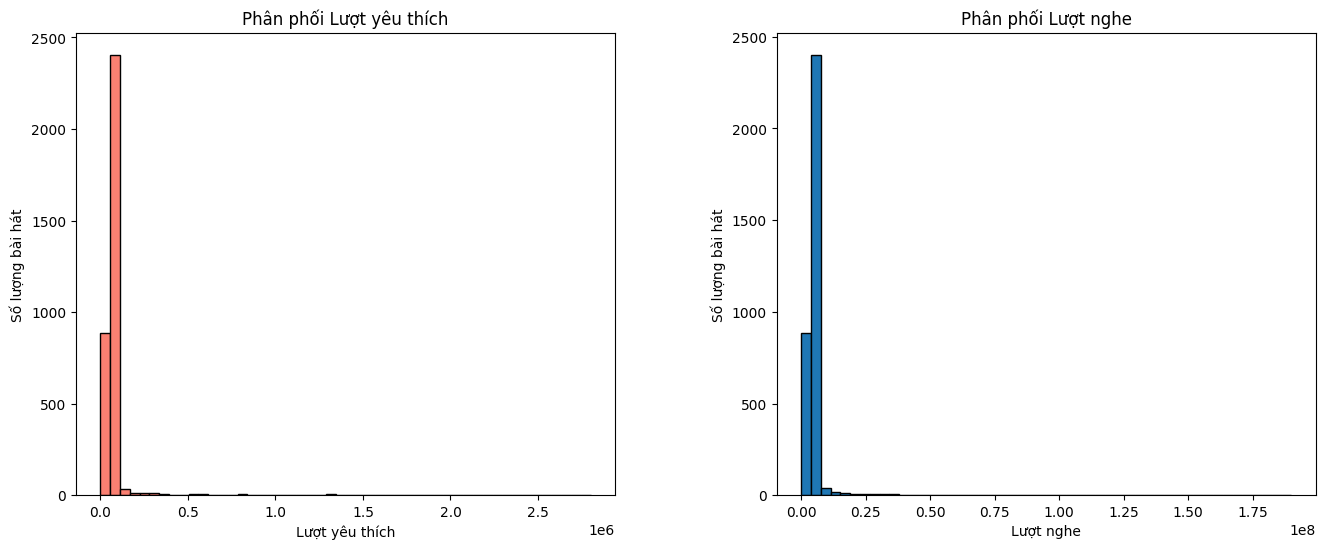

In [48]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.hist(df_cleaned['Lượt yêu thích'], color='salmon', bins=50, edgecolor='black')
plt.title("Phân phối Lượt yêu thích")
plt.xlabel('Lượt yêu thích')
plt.ylabel('Số lượng bài hát')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.hist(df_cleaned['Lượt nghe'], bins=50, edgecolor='black')
plt.title("Phân phối Lượt nghe")
plt.xlabel('Lượt nghe')
plt.ylabel('Số lượng bài hát')

plt.subplots_adjust(wspace=0.3)
plt.show()


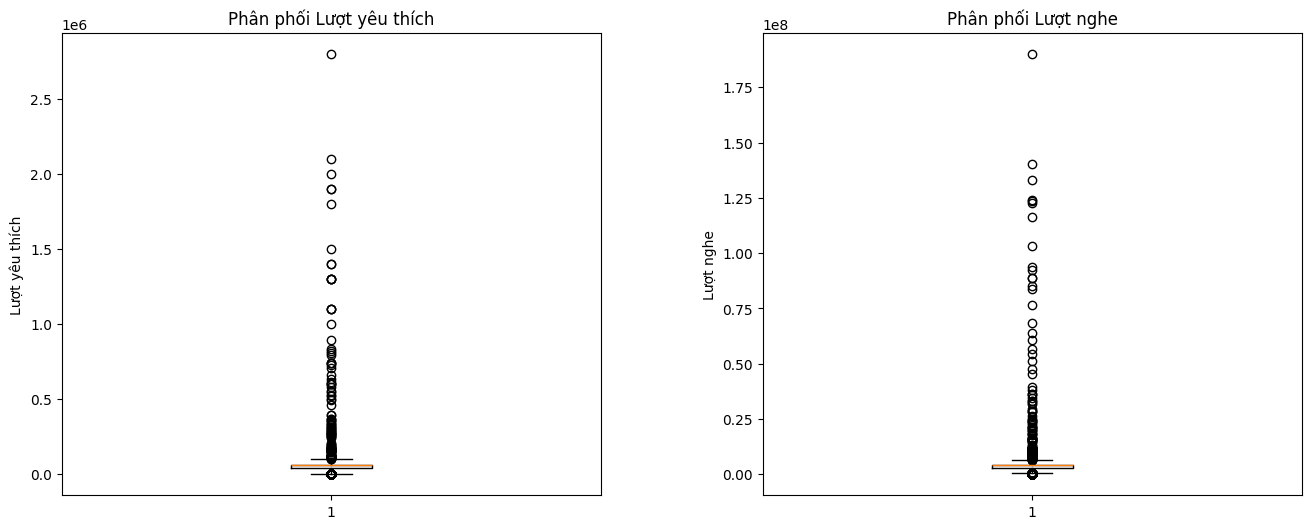

In [49]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'])
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'])
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


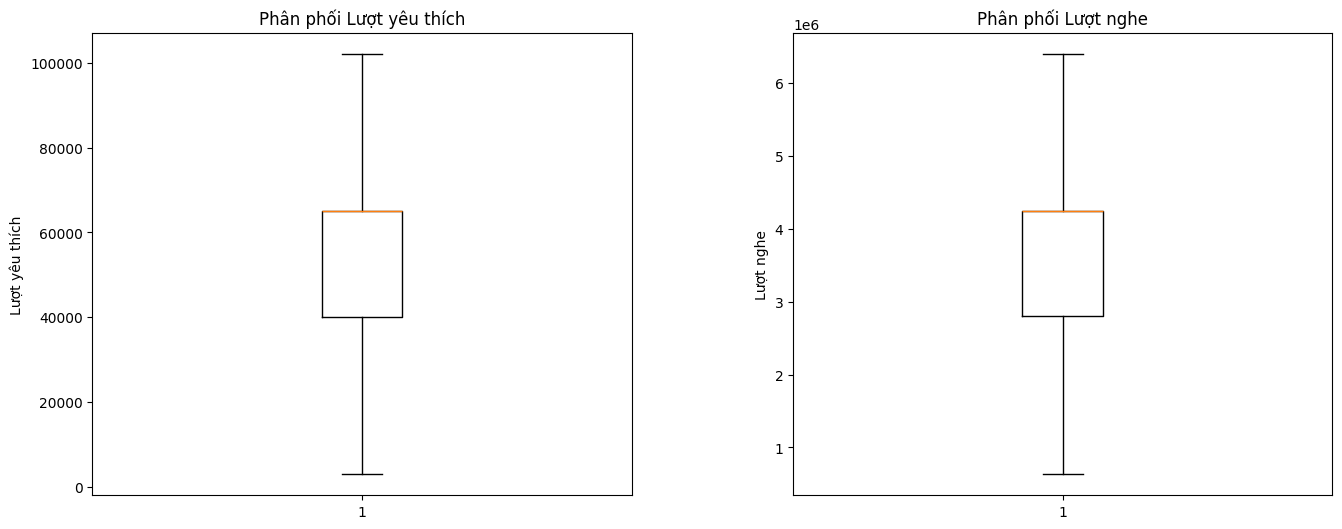

In [50]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'], showfliers=False)
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'], showfliers=False)
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


$\rightarrow$ So với ban đầu, các khoảng tứ phân vị và phân bố giá trị có sự thay đổi tăng lên đáng kể. Hơn nữa, phân phối cũng đều hơn so với ban đầu, khi so với ban đầu, không còn tập trung quá mức ở một phạm vi nhỏ.

<Axes: >

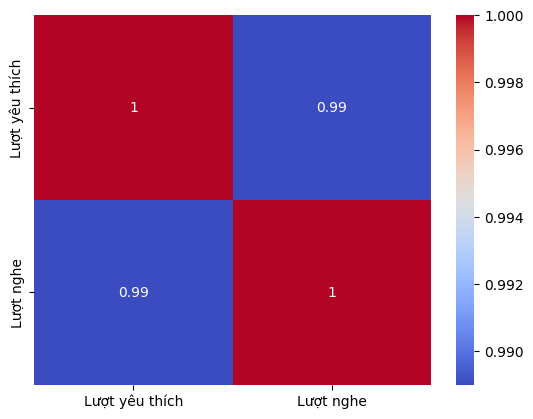

In [51]:
numeric_df = df_cleaned.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr().round(3)

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

$\rightarrow$ Sự tương quan giữa lượt nghe và lượt cực kì cao. Nghĩa là cả 2 cột này đều có xu hướng thay đổi giống nhau.

#### **Các cột có dữ liệu số phân phối như nào?**

In [52]:
cat_cols = df_cleaned.select_dtypes(include=['category', 'object']).drop(columns=['Lượt yêu thích (dễ nhìn)', 'Lượt nghe (dễ nhìn)', 'Thể loại'], errors='ignore')

In [53]:
def value_ratios(column):
    value_count_percentage = column.value_counts(normalize=True) * 100
    ratio = value_count_percentage.sort_values(ascending=False).round(2).to_dict()
    return ratio

In [54]:
cat_col_ratio = cat_cols.agg([value_ratios])
cat_col_ratio

,Tên bài hát,Album,Nghệ sĩ,Sáng tác,Nhà cung cấp,Quốc gia,Thể loại chính
value_ratios,"{'Còn Tuổi Nào Cho Em': 0.18, 'Mưa Hồng': 0.15, 'Someone You Loved': 0.12, 'Flowers': 0.12, 'Cô Ba': 0.12, 'Em Còn Nhớ Hay Em Đã Quên': 0.12, 'Tuổi Đá Buồn': 0.12, 'Đừng Hỏi Em Ổn Không…': 0.12, 'Người Tình Trên Chiến Trận': 0.12, 'Một Cõi Đi Về': 0.12, 'Nắng Thủy Tinh': 0.12, 'Numb': 0.09, 'Con Cò Bé Bé': 0.09, 'Đừng Trách Câu Ví Dặm': 0.09, 'Đêm Lạnh Chùa Hoang': 0.09, 'Lucky': 0.09, 'Biển Nhớ': 0.09, 'Ngày Mai Người Ta Lấy…': 0.09, 'Cát Bụi': 0.09, 'Hạ Trắng': 0.09, 'Nỗi Buồn Em Đánh Rơi…': 0.09, 'Tìm Em Câu Ví Sông Lam': 0.09, '凝眸': 0.09, 'Lý Chim Quyên': 0.09, 'Bài Ca Xây Dựng': 0.09, 'Adagio Concerto For Oboe…': 0.09, 'Diễm Xưa': 0.09, 'Anh Thôi Nhân Nhượng…': 0.09, 'Hà Tĩnh Quê Ơi': 0.09, 'Tình Nhớ': 0.09, 'Đò Sang Ngang': 0.06, 'Fall In Love': 0.06, 'Waterfall': 0.06, 'Huyền Thoại Mẹ': 0.06, 'Allegro Concerto For Oboe…': 0.06, 'Cô Đôi Thượng Ngàn': 0.06, 'Ôm Sầu (Remix)': 0.06, 'Gurenge': 0.06, 'Send It': 0.06, 'Ru Ta Ngậm Ngùi': 0.06, '8 Vạn 6 Ngàn Thương': 0.06, 'E Là Không Thể': 0.06, 'Smile': 0.06, 'Sumeru Aranara Song…': 0.06, 'Gorg Philipp Telemann…': 0.06, 'Phôi Pha': 0.06, 'Kiếp Sau Vẫn Muốn Lập Gia…': 0.06, 'Skibidi Toilet (Remix)': 0.06, 'Lemon Tree': 0.06, 'Cuối Cùng Cho Một Tình Yêu': 0.06, 'Trả Lại Thanh Xuân Cho Em…': 0.06, 'Ăn Trông Nồi Ngồi Trông…': 0.06, 'Từng Ngày Yêu Em': 0.06, 'Johann Friedrich Fasch…': 0.06, 'Blue': 0.06, 'Đêm Thấy Ta Là Thác Đổ': 0.06, 'Bones': 0.06, 'Như Cánh Vạc Bay': 0.06, 'Trầu Cau Quan Họ': 0.06, 'Buồn Con Sáo Sậu': 0.06, 'Closer': 0.06, 'Lao Tâm Khổ Tứ': 0.06, 'Today': 0.06, 'Cá Vàng Bơi': 0.06, 'Love, Maybe': 0.06, 'Tuổi Đời Mênh Mông': 0.06, 'Khóc Nơi Ta Cười': 0.06, 'KHÔNG RA GÌ': 0.06, 'Khi Yêu Nào Đâu Ai Muốn…': 0.06, 'Charlie Brown Medley': 0.06, 'Chiếc Lá Thu Phai': 0.06, 'Em Cua Ngay Hom Qua…': 0.06, 'Em Có Bằng Lòng Về Quê…': 0.06, 'Hương Tình Bến Tre': 0.06, 'Duyên Nợ Miền Tây': 0.06, 'Đêm Mưa Nhớ Mẹ': 0.06, 'The Moment': 0.06, 'Vương Vấn (Qinn Remix)': 0.06, 'Ướt Mi': 0.06, 'Ru Đời Đi Nhé': 0.06, 'Tái Sinh': 0.06, 'Cung Đàn Mới': 0.06, 'Save Me': 0.06, 'Chiều Một Mình Qua Phố': 0.06, 'Chăm Em Một Đời': 0.06, 'Để Gió Cuốn Đi': 0.06, 'Slowly': 0.06, 'Dấu Chân Địa Đàng': 0.06, 'Rượu Mừng Hóa Người…': 0.06, 'Time Back': 0.06, 'Gửi Người Em Hà Tĩnh': 0.06, 'Ngày Này, Người Con Gái Này': 0.06, 'Heather On The Hill…': 0.06, 'FOREVER': 0.06, 'Words': 0.06, 'Khổ Quá Thì Về Mẹ Nuôi': 0.06, 'Going Home': 0.06, 'Nhớ': 0.06, 'Supernova Love': 0.06, 'Die With A Smile': 0.06, ...}","{'Canti Per La Liturgia, Vol. 4: A Collection of Christian Songs and Catholic Hymns (Single)': 0.85, 'Smooth Piano Jazz Music': 0.71, 'Canti Per La Liturgia, Vol. 5: A Collection of Christian Songs and Catholic Hymns (Single)': 0.68, 'Clasicos Infantiles': 0.62, 'Squid Game 2 (Soundtrack from the Netflix Series)': 0.62, 'Fingerstyle Guitar (Single)': 0.59, 'Nhạc Relax Minh Thống': 0.5, 'Hồ Yêu Tiểu Hồng Nương: Nguyệt Hồng Thiên (OST) / 电视剧《狐妖小红娘月红篇》原声带': 0.5, 'Hurry Up Tomorrow': 0.5, 'Un bel di': 0.41, 'Luxury Classics - A Touch of Class -': 0.41, 'Tuyển Tập Nhạc Trịnh (Vol 2)': 0.38, 'Tuyển Tập Nhạc Trịnh': 0.35, 'Trịnh Ca Vol. 1': 0.35, 'Chess Fantasies (Single)': 0.32, 'Tiếng Sáo Chiều': 0.32, 'Louie O.': 0.32, 'Trịnh Ca Vol. 2': 0.32, 'Our Acoustic Life (Single)': 0.32, 'Saxophone Memories (Single)': 0.29, 'Speak Now (Taylor's Version)': 0.29, 'Đi Đến Nơi Có Gió (OST) / 電視劇《去有風的地方》原聲帶': 0.29, 'Music Box Collection Suda Masaki Song Collection': 0.29, 'Hòa Tấu Guitar': 0.29, 'Ai Cũng Phải Bắt Đầu Từ Đâu Đó': 0.29, 'Liên Hoa Lâu (OST) / 《莲花楼》电视剧原声专辑': 0.29, 'Trịnh Ca 05': 0.29, 'Nhạc Thánh Ca Không Lời Piano Nhẹ Nhàng': 0.29, 'Nguyễn Hải Phong - Nhạc Piano Không Lời Vol.1': 0.29, 'TRỜI ĐÁNH TRÁNH TA - TA VA TRÚNG NGƯỜI': 0.29, 'Relax piano - yellow jelly': 0.29, 'Slow Saxophone Smooth Jazz Music For Lover': 0.29, 'REMIX RUMBLE (Original Soundtrack from Teamfight Tactics Set 10)': 0.26, 'DRIP': 0.26, 'Album Hoa Ta

In [55]:
import warnings
warnings.filterwarnings("ignore")

In [56]:
def plot_pie_chart(column, title, ax):
    ratios = value_ratios(column)
    
    top_10_ratios = dict(list(ratios.items())[:10])
    
    labels = list(top_10_ratios.keys())
    sizes = list(top_10_ratios.values())
    
    labels = [label if len(label) <= 21 else '\n'.join([label[i:i+21] for i in range(0, len(label), 21)]) for label in labels]
    explode = [0.1 if i == sizes.index(max(sizes)) else 0 for i in range(len(sizes))]
    
    pastel_colors = sns.color_palette("pastel", len(sizes))
    
    # Plot pie chart with adjusted label distance and angle
    ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, labeldistance=1.2, pctdistance=0.85, explode=explode, colors=pastel_colors)
    ax.set_title(title, pad=15)
    plt.axis('equal')

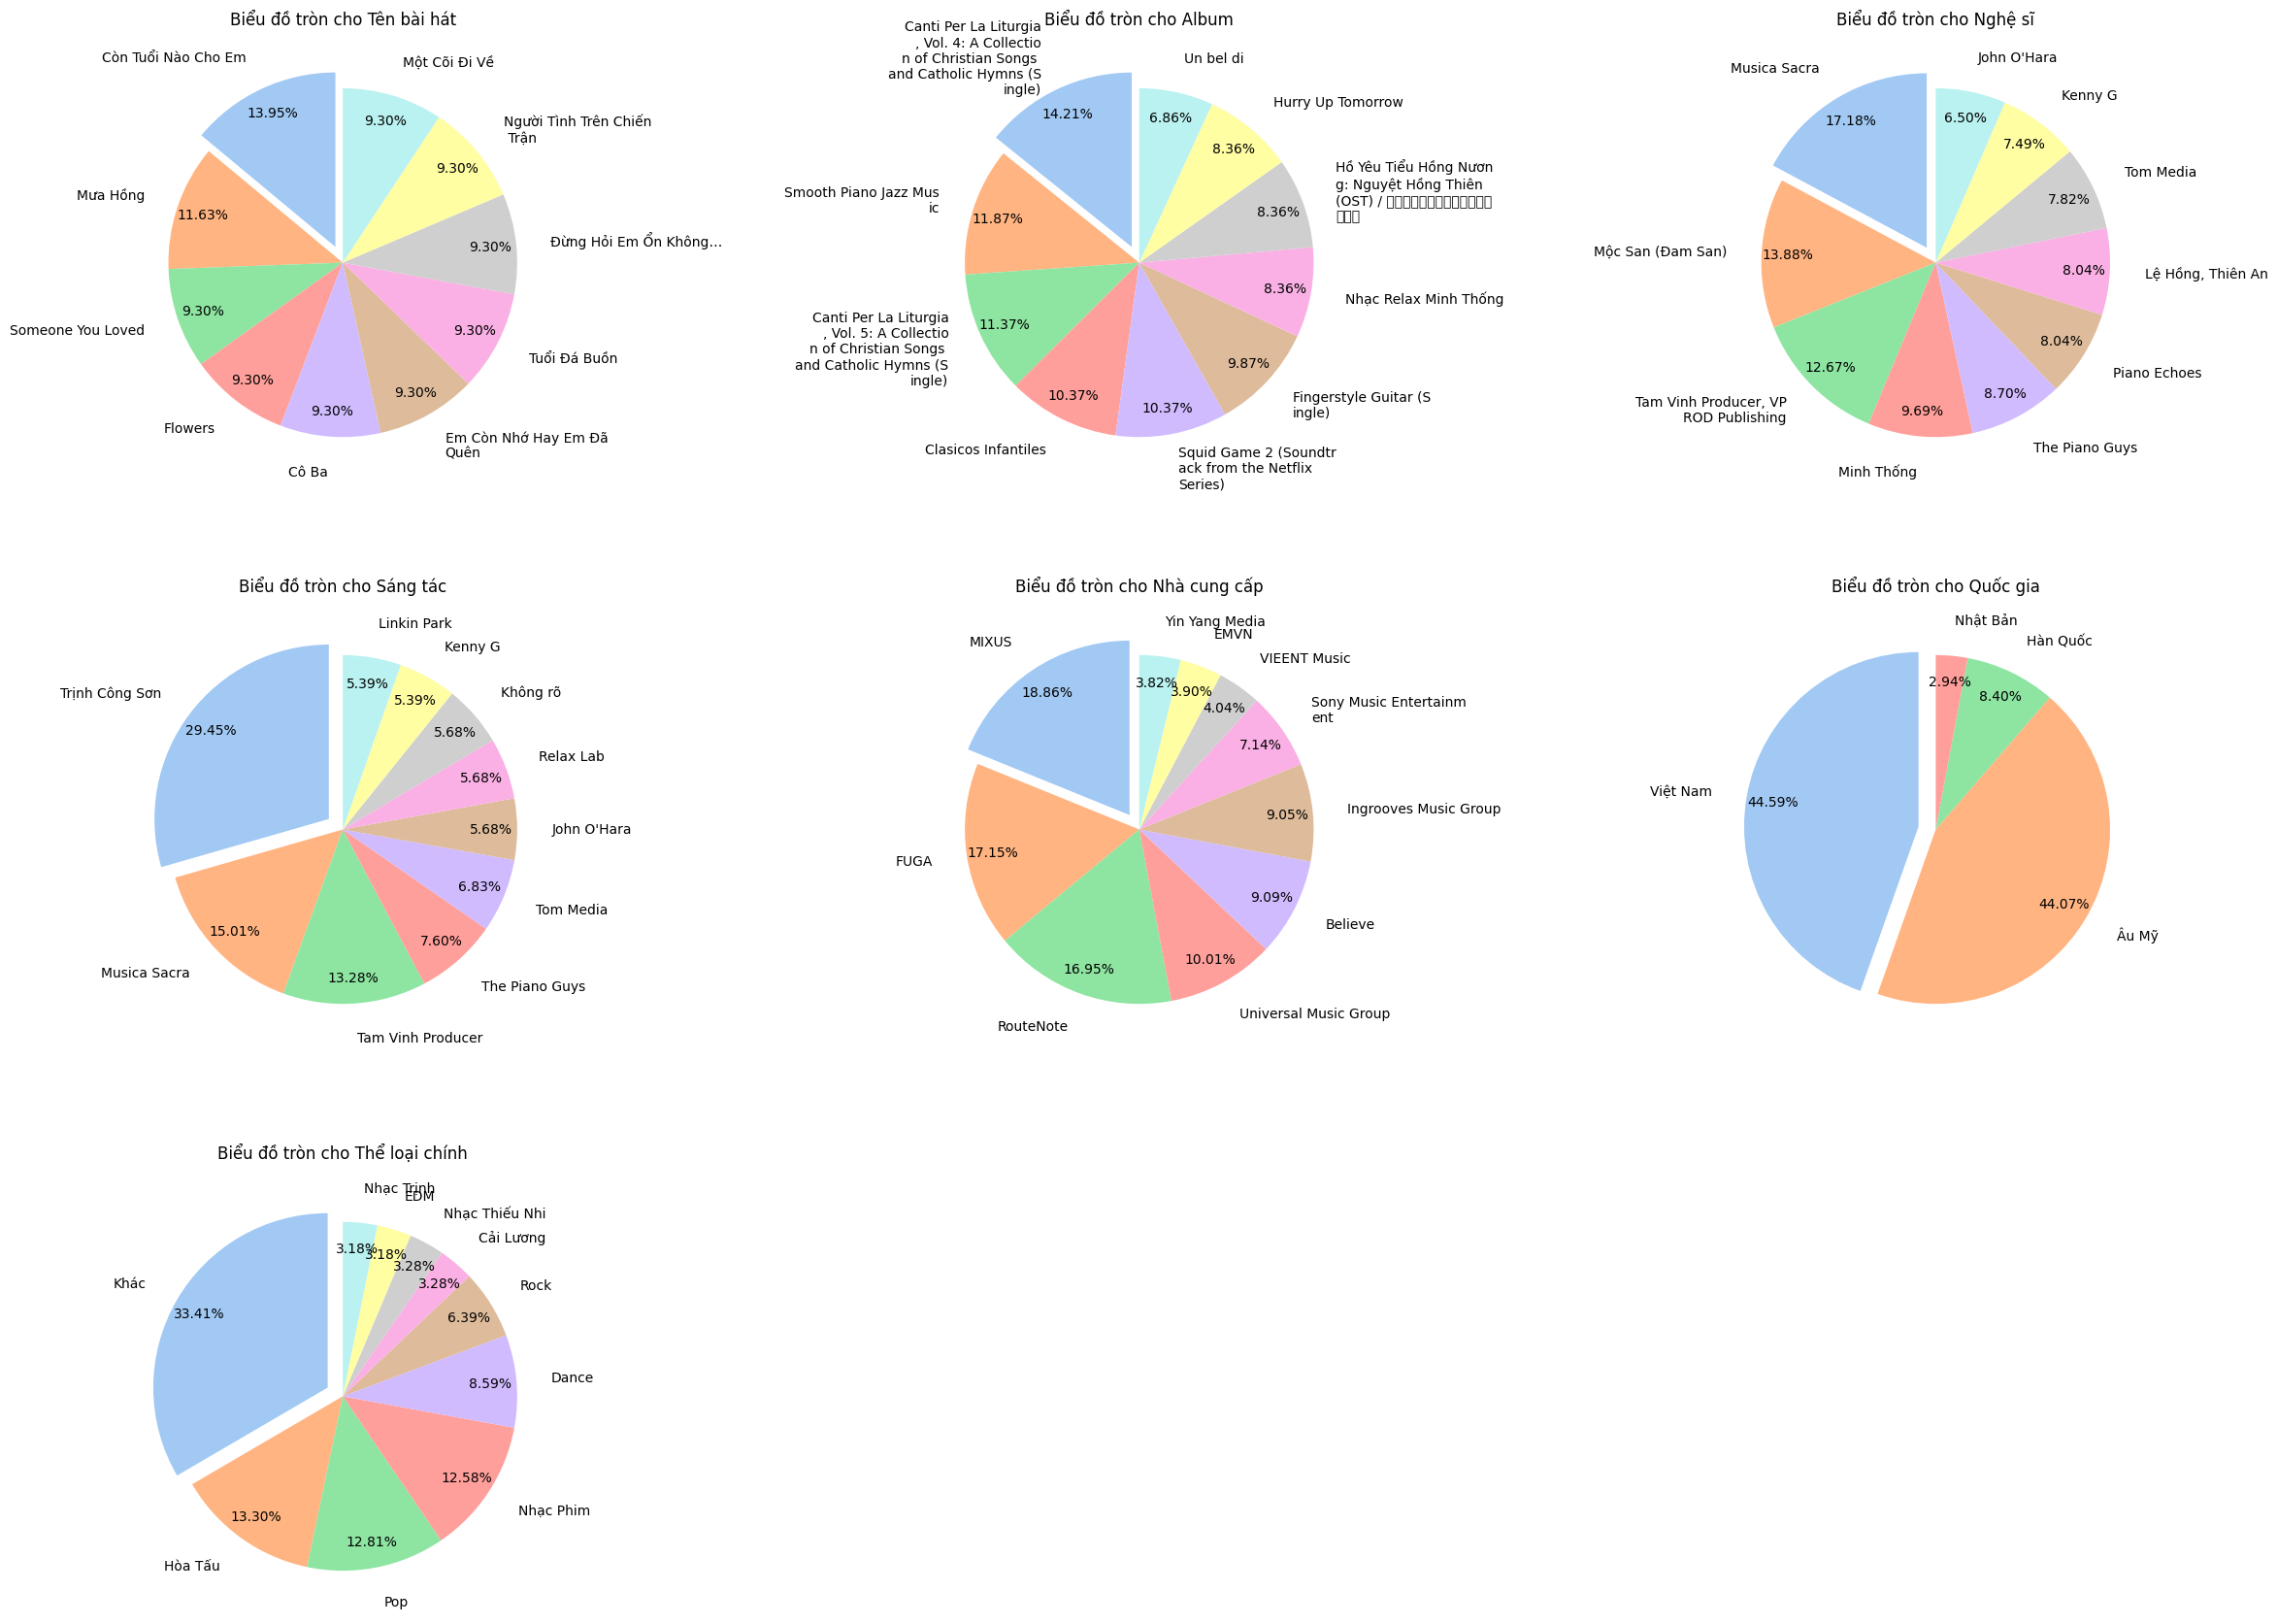

In [57]:
num_cols = len(cat_cols.columns)
rows = (num_cols // 3) + 1  # Số dòng
fig, axes = plt.subplots(rows, 3, figsize=(30, 7 * rows))

axes = axes.flatten()

for i, col in enumerate(cat_cols.columns):
    plot_pie_chart(df_cleaned[col], title=f"Biểu đồ tròn cho {col}", ax=axes[i])

for i in range(num_cols, len(axes)):
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.3) 
plt.show()

Một số kết luận có thể rút ra:
- Ở `Tên bài hát`, bài **'Còn Tuổi Nào Cho Em'**, **'Mưa Hồng'** có tỷ lệ lớn hơn hẳn so với nhiều bài. Đây là những bài hát được trình bày bởi nhiều ca nghệ sĩ khác nhau và xuất hiện nhiều lần trong các album top 100, có thể thấy được đây là những bài hát hay được rất nhiều người nghe, bởi ý nghĩa mà bài hát mang lại hoặc có thể bởi những giai điệu nhẹ nhàng, sâu lắng, bắt tai... Theo sau đó, **Someone You Loved**, **Flowers**, .... Phần lớn là nhạc Việt Nam, cho thấy xu hướng người dùng trên nền tảng ZingMP3 thích nhạc Việt.
- Ngược hẳn với `Tên bài hát` thì `Album`, `Sáng tác` xuất hiện nhiều nhất trong các nền tảng lại là các album và các nhạc sĩ sáng tác ở nước ngoài.
- Trên nền tảng Zing MP3, 'MIXUE', 'FUGA', 'RouteNote' là các `Nhà cung cấp` bài hát, album lớn nhất. 'Universal Music Group', 'Belive' cũng là những hãng thu âm nổi tiếng ở Việt Nam này.
- Phần lớn nhạc trên Zing MP3 là nhạc Việt Nam và nhạc Âu Mỹ
- Có rất nhiều thể loại nhạc khác nhau trên nền tảng nghe nhạc Zing MP3,  trong đó nổi bật nhất trong các album top 100 là các thể loại nhạc 'Hòa Tấu', 'Pop' và 'Nhạc Phim'

----

## **Phần 2: Đặt câu hỏi**

### **Tổng hợp câu hỏi**

##### **Câu 1:** Nghệ sĩ nào đang dẫn đầu trong lượt nghe và lượt thích trong các album Top 100? Thể loại nhạc nào phổ biến nhất đã được trình bày?
##### **Câu 2:** Top 5 thể loại nhạc nào phổ biến nhất hiện nay? Tổng các lượt yêu thích và lượt nghe có phải có xu hướng giảm theo thứ tự?
##### **Câu 3:** Ở mỗi quốc gia, thể loại nào là phổ biến nhất?
##### **Câu 4:** Hãy cùng nhau xem xu hướng nhạc ở Việt Nam như thế nào?

<br>

### **Câu 1. Các nghệ sĩ nào đang dẫn đầu trong lượt nghe và lượt thích trong các album Top 100? Thể loại nhạc nào phổ biến nhất đã được trình bày?**

#### **Top 10 nghệ sĩ có nhiều lượt yêu thích nhất**

In [58]:
# Tính tổng lượt yêu thích của từng nghệ sĩ
df_nghesi_luotyeuthich = df_cleaned.groupby('Nghệ sĩ')['Lượt yêu thích'].sum().sort_values(ascending=False).reset_index().rename(columns={'Lượt yêu thích':'Tổng lượt yêu thích'})

df_nghesi_luotyeuthich.head(10)

,Nghệ sĩ,Tổng lượt yêu thích
0,Thành Đạt,6427000.0
1,Musica Sacra,3444735.0
2,Keyo,2984000.0
3,Khang Việt,2640000.0
4,Thiên Tú,2021995.0
5,"Tăng Duy Tân, Drum7",1800000.0
6,Thái Học,1782980.0
7,The Piano Guys,1754865.0
8,Dương Hồng Loan,1750936.0
9,Piano Echoes,1624875.0


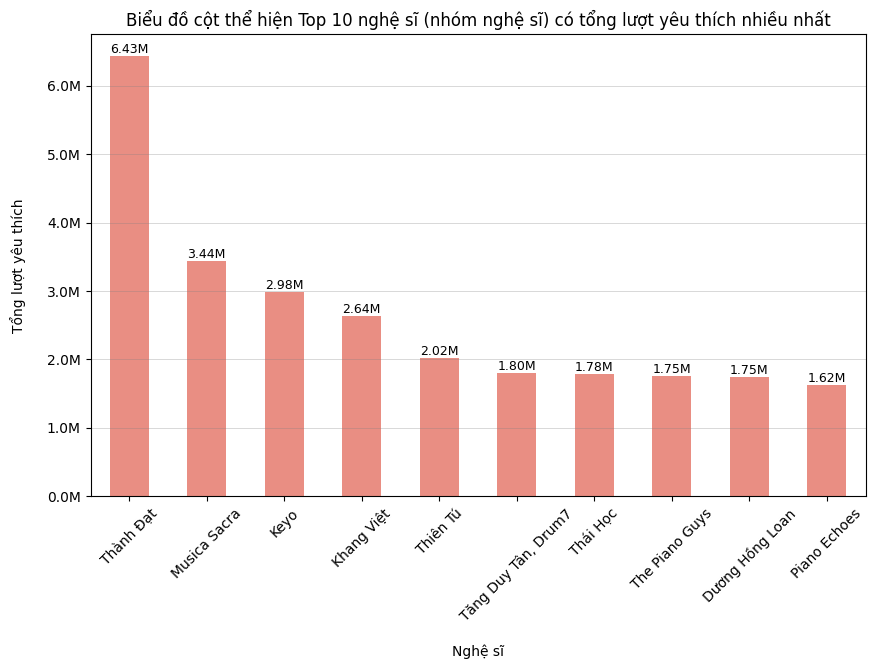

In [59]:
df_nghesi_luotyeuthich_top10 = df_nghesi_luotyeuthich.head(10)

plt.figure(figsize=(10, 6))

sns.barplot(data=df_nghesi_luotyeuthich_top10, x='Nghệ sĩ', y='Tổng lượt yêu thích', color='salmon', width=0.5)

plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.7, color='gray', alpha=0.3)

plt.title('Biểu đồ cột thể hiện Top 10 nghệ sĩ (nhóm nghệ sĩ) có tổng lượt yêu thích nhiều nhất')

plt.xticks(rotation=45)
ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(tick*1e-6):.1f}M' for tick in ticks])

plt.xlabel('Nghệ sĩ', labelpad=15)
plt.ylabel('Tổng lượt yêu thích', labelpad=15)


for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{height*1e-6:.2f}M',
             ha='center', va='bottom', fontsize=9, color='black')

plt.show()

In [60]:
top_10_nghesi = df_nghesi_luotyeuthich_top10['Nghệ sĩ']

df_top10 = df_cleaned[df_cleaned['Nghệ sĩ'].isin(top_10_nghesi)]

# Lấy ra thể loại chính phổ biến nhất cho mỗi nghệ sĩ
top_theloai_nghesi = df_top10.groupby('Nghệ sĩ')['Thể loại chính'].value_counts()

top_theloai_nghesi = top_theloai_nghesi.loc[df_nghesi_luotyeuthich_top10['Nghệ sĩ']].reset_index(name='Số bài hát')

top_theloai_nghesi


,Nghệ sĩ,Thể loại chính,Số bài hát
0,Thành Đạt,Pop,4
1,Thành Đạt,Dance,2
2,Musica Sacra,Khác,53
3,Keyo,Dance,1
4,Keyo,Pop,1
5,Khang Việt,Dance,4
6,Khang Việt,Pop,2
7,Thiên Tú,Pop,4
8,Thiên Tú,Dance,3
9,Thiên Tú,Khác,1


In [61]:
top_theloai = top_theloai_nghesi.groupby('Thể loại chính')['Số bài hát'].sum().sort_values(ascending=False).reset_index()

top_theloai


,Thể loại chính,Số bài hát
0,Khác,65
1,Hòa Tấu,49
2,Pop,19
3,Dance,10
4,Nhạc Phim,1


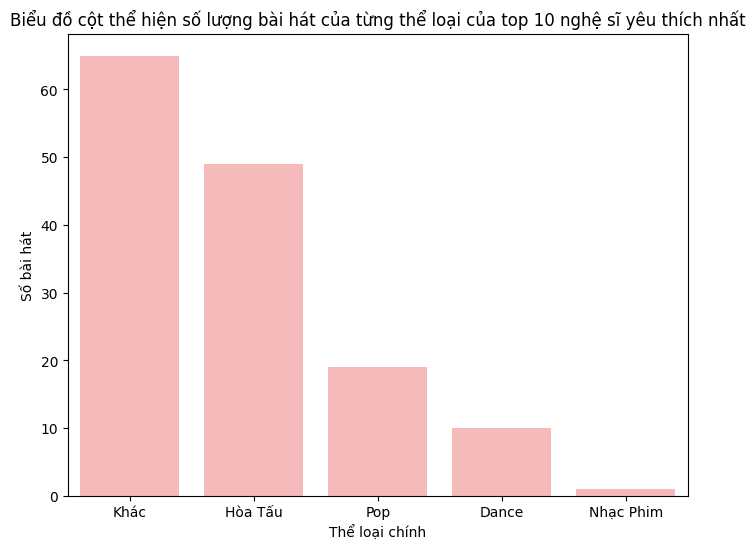

In [62]:
plt.figure(figsize=(8, 6))

plt.title('Biểu đồ cột thể hiện số lượng bài hát của từng thể loại của top 10 nghệ sĩ yêu thích nhất')

sns.barplot(data=top_theloai, x='Thể loại chính', y='Số bài hát', color='red', alpha=0.3)

plt.show()

Một số quan sát được rút ra:
- Nghệ sĩ Thành Đạt là một nghệ sĩ có tổng số lượt yêu thích nhiều nhất, nổi bật nhất trong tất cả các nghệ sĩ top 10 khác, với 6 bài hát (4 bài thuộc thể loại Pop và 2 bài thuộc thể loại Dance) có tổng số lượng tổng yêu thích đến 6.43 triệu lượt thích.
- Theo sau đó, Musica Sacra (Nhạc nhà thờ), Keyo, Khang Việt, Thiên Tú là những (nhóm) nghệ sĩ có có tổng lượt yêu thích trên 2 triệu, lần lượt là 3.44 triệu, 2.98 triệu, 2.64 triệu và 2.02 triệu lượt yêu thích.
- Top 5 (nhóm) nghệ sĩ còn lại cũng nổi bật với tổng số lượt yêu thích đáng kể trên 1.6 triệu lượt yêu thích.  Cho thấy sự yêu thích mạnh mẽ từ công chúng đối với nhiều phong cách âm nhạc khác nhau.
- Nhiều thể loại được trình bày bới top 10 nghệ sĩ được yêu thích nhất. Hòa tấu là một trong những thể loại đó, bởi âm thanh nhẹ nhàng, dao hưởng có thể giúp người nghe và người biểu diễn cảm thấy dễ chịu, thấy thư giãn đầu óc

#### **Top 10 nghệ sĩ có nhiều lượt nghe nhất**

In [63]:
# Tính tổng lượt nghe của từng nghệ sĩ
df_nghesi_luotnghe = df_cleaned.groupby('Nghệ sĩ')['Lượt nghe'].sum().sort_values(ascending=False).reset_index().rename(columns={'Lượt nghe':'Tổng lượt nghe'})

df_nghesi_luotnghe.head(10)

,Nghệ sĩ,Tổng lượt nghe
0,Thành Đạt,428600000.0
1,Musica Sacra,225063175.0
2,Keyo,201500000.0
3,Khang Việt,176200000.0
4,Thiên Tú,131946475.0
5,Thái Học,127385900.0
6,"Tăng Duy Tân, Drum7",122800000.0
7,Phát Huy T4,117700000.0
8,The Piano Guys,114654825.0
9,Piano Echoes,106161875.0


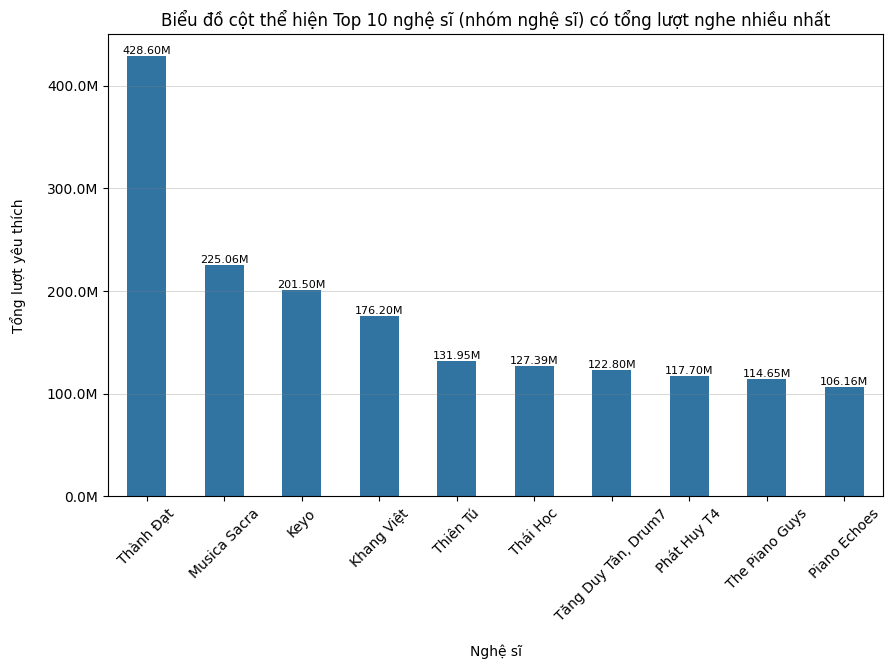

In [64]:
df_nghesi_luotnghe_top10 = df_nghesi_luotnghe.head(10)

plt.figure(figsize=(10, 6))

sns.barplot(data=df_nghesi_luotnghe_top10, x='Nghệ sĩ', y='Tổng lượt nghe', width=0.5)

plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.7, color='gray', alpha=0.3)

plt.title('Biểu đồ cột thể hiện Top 10 nghệ sĩ (nhóm nghệ sĩ) có tổng lượt nghe nhiều nhất')

plt.xticks(rotation=45)
ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(tick*1e-6):.1f}M' for tick in ticks])

plt.xlabel('Nghệ sĩ', labelpad=15)
plt.ylabel('Tổng lượt yêu thích', labelpad=15)


for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{height*1e-6:.2f}M',
             ha='center', va='bottom', fontsize=8, color='black')

plt.show()

In [65]:
top_10_nghesi_nghe = df_nghesi_luotnghe_top10['Nghệ sĩ']

df_top10 = df_cleaned[df_cleaned['Nghệ sĩ'].isin(top_10_nghesi_nghe)]

top_theloai_nghesi = df_top10.groupby('Nghệ sĩ')['Thể loại chính'].value_counts()

top_theloai_nghesi = top_theloai_nghesi.loc[df_nghesi_luotnghe_top10['Nghệ sĩ']].reset_index(name='Số bài hát')

top_theloai_nghesi


,Nghệ sĩ,Thể loại chính,Số bài hát
0,Thành Đạt,Pop,4
1,Thành Đạt,Dance,2
2,Musica Sacra,Khác,53
3,Keyo,Dance,1
4,Keyo,Pop,1
5,Khang Việt,Dance,4
6,Khang Việt,Pop,2
7,Thiên Tú,Pop,4
8,Thiên Tú,Dance,3
9,Thiên Tú,Khác,1


In [66]:
top_theloai = top_theloai_nghesi.groupby('Thể loại chính')['Số bài hát'].sum().sort_values(ascending=False).reset_index()

top_theloai

,Thể loại chính,Số bài hát
0,Khác,56
1,Hòa Tấu,49
2,Pop,20
3,Dance,11
4,Nhạc Phim,1


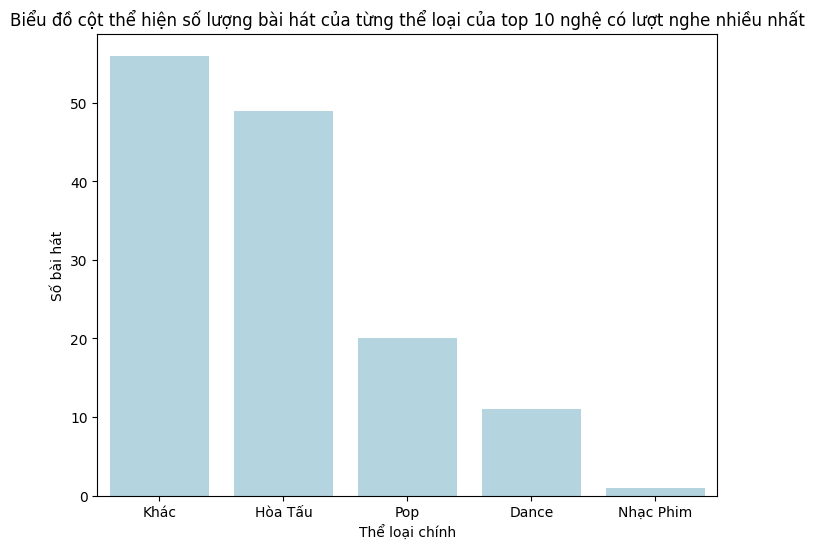

In [67]:
plt.figure(figsize=(8, 6))

plt.title('Biểu đồ cột thể hiện số lượng bài hát của từng thể loại của top 10 nghệ có lượt nghe nhiều nhất')

sns.barplot(data=top_theloai, x='Thể loại chính', y='Số bài hát', color='lightblue')

plt.show()

Một số kết luận rút ra:
- Nghệ sĩ Thành Đạt cũng là nghệ sĩ có tổng lượt yêu thích cao nhất, nổi bật so với các nghệ sĩ trong Top 10, với 6 bài hát có tổng số lượt yêu thích lên đến 428.60 triệu lượt.
- Tiếp theo là Musica Sacra (Nhạc nhà thờ), Keyo, là 2 nghệ sĩ có tổng lượt yêu thích vượt trên 200 triệu, lần lượt là 225.06 triệu và 201.50 triệu
- Các nghệ sĩ còn lại trong Top 10 cũng có tổng lượt yêu thích đáng kể, với hơn 100 triệu lượt yêu thích, cho thấy sự yêu thích mạnh mẽ từ công chúng đối với nhiều phong cách âm nhạc khác nhau.
- Các thể loại âm nhạc đa dạng xuất hiện trong Top 10 nghệ sĩ có nhiều lượt nghe nhất cũng bao gồm Pop, Dance, và Hòa tấu. Tương tự như lượt yêu thích, Hòa tấu là một thể loại nổi bật.

$\Rightarrow$ **Kết luận chung**:
- Nghệ sĩ Thành Đạt là người nổi bật nhất trong Top 10 với tổng số lượt yêu thích và lượt nghe, chiếm ưu thế mạnh mẽ, vượt trội hơn so với các nghệ sĩ khác.
- Musica Sacra và Keyo là hai nghệ sĩ kế tiếp cũng có số lượt yêu thích và nghe vô cùng đáng kể, chiếm vị trí top 2 và top 3 trong bảng xếp hạng ở 2 hạng mục.
- Các nghệ sĩ còn lại trong Top 10 cũng giữ được sự yêu mến mạnh mẽ với nhiều thể loại âm nhạc từ Pop, Dance cho đến Hòa tấu.

---

### **Câu 2. Top 5 thể loại nhạc nào phổ biến nhất hiện nay? Xu hướng lượt nghe và lượt yêu thích có giống nhau không?**

In [68]:
df_by_theloai_counts = df_cleaned['Thể loại chính'].value_counts().reset_index(name='Số bài hát')

df_by_theloai_counts

,Thể loại chính,Số bài hát
0,Khác,1020
1,Hòa Tấu,406
2,Pop,391
3,Nhạc Phim,384
4,Dance,262
5,Rock,195
6,Cải Lương,100
7,Nhạc Thiếu Nhi,100
8,EDM,97
9,Nhạc Trịnh,97


- Để ý thấy `Thể loại chính` là *Khác* có số lượng lớn hơn hẳn so với các thể loại khác, ngoài ra, thể loại *Khác* chứa rất nhiều thể loại khác nhau bên cạnh những thể loại đã được hiện ở bên trên. Thể nên, để thuận tiện cho việc phân tích, chúng em quyết định tạm thời bỏ thể loại *Khác* đó.

In [69]:
df_by_theloai_counts = df_by_theloai_counts.drop(labels=[0])

df_by_theloai_counts

,Thể loại chính,Số bài hát
1,Hòa Tấu,406
2,Pop,391
3,Nhạc Phim,384
4,Dance,262
5,Rock,195
6,Cải Lương,100
7,Nhạc Thiếu Nhi,100
8,EDM,97
9,Nhạc Trịnh,97
10,Country,92


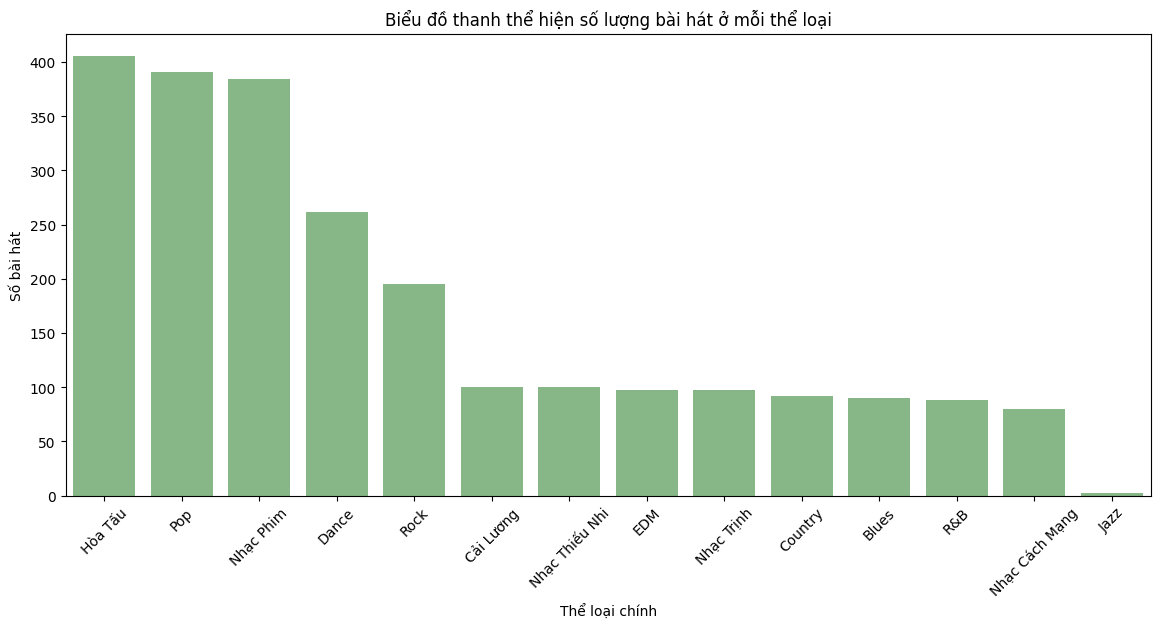

In [70]:
plt.figure(figsize=(14, 6))

sns.barplot(data=df_by_theloai_counts, x='Thể loại chính', y='Số bài hát', color='green', alpha=0.5)

plt.title('Biểu đồ thanh thể hiện số lượng bài hát ở mỗi thể loại')

plt.xticks(rotation=45)

plt.show()

Một số kết luận được rút ra:
- Trên nền tảng âm nhạc Zing MP3, có rất nhiều thể loại được nhiều người nghe, Hòa Tấu là thể loại có nhiều bài hát nhất với 406 bài hát.
- Theo sau đó, không thua kém đó là nhạc Pop và nhạc phim, mỗi thể loại này đều sở hữu gần 400 bài hát, thể hiện sức hút mạnh mẽ trong cộng đồng người yêu nhạc.
- Thể loại nhạc Dance và nhạc Rock cũng khá nổi tiếng và được nhiều nghệ sĩ trình bài, khi lần lượt được ghi nhận 262 bài thuộc thể loại Dance và 195 bài thuộc thể Rock, chứng minh sự đa dạng và phong phú trong gu âm nhạc của người nghe và nghệ sĩ.
- Với các thể loại còn lại, ngoài thể loại nhạc Jazz với chỉ có 2 bài hát, thì số lượng bài cũng tương đối nhiều, đạt trên 80-100 bài hát.

#### Chọn top 5 thể loại phổ biến nhất

In [71]:
top_5_theloai_counts = df_by_theloai_counts.head(5)

top_5_theloai_counts

,Thể loại chính,Số bài hát
1,Hòa Tấu,406
2,Pop,391
3,Nhạc Phim,384
4,Dance,262
5,Rock,195


#### Tính tổng lượt nghe và lượt yêu thích của top 5 thể loại

In [72]:
top_5_theloai = top_5_theloai_counts['Thể loại chính']

df_top_5_theloai = df_cleaned[df_cleaned['Thể loại chính'].isin(top_5_theloai)]

top_5_theloai_luotnghe = df_top_5_theloai.groupby('Thể loại chính')['Lượt nghe'].sum().sort_values(ascending=False).reset_index().rename(columns={'Lượt nghe':'Tổng lượt nghe'})

top_5_theloai_luotyeuthich = df_top_5_theloai.groupby('Thể loại chính')['Lượt yêu thích'].sum().sort_values(ascending=False).reset_index().rename(columns={'Lượt yêu thích':'Tổng lượt yêu thích'})

In [73]:
top_5_theloai_luotnghe

,Thể loại chính,Tổng lượt nghe
0,Pop,4.019137e+09
1,Hòa Tấu,1.571055e+09
2,Nhạc Phim,1.408513e+09
3,Dance,1.360882e+09
4,Rock,5.416850e+08


In [74]:
top_5_theloai_luotyeuthich

,Thể loại chính,Tổng lượt yêu thích
0,Pop,62868668.0
1,Hòa Tấu,24045652.0
2,Nhạc Phim,21653580.0
3,Dance,21105130.0
4,Rock,8291014.0


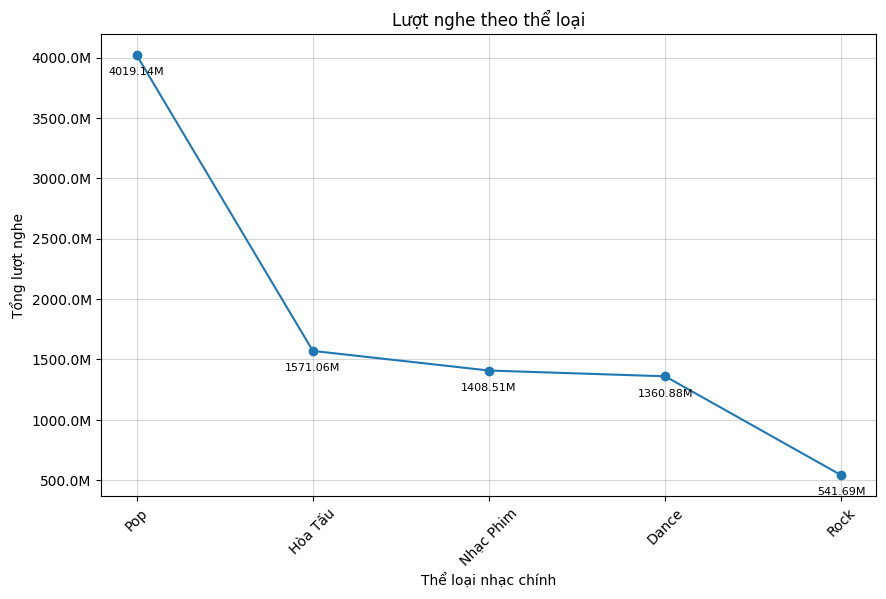

In [75]:
plt.figure(figsize=(10, 6))

plt.plot(top_5_theloai_luotnghe['Thể loại chính'], top_5_theloai_luotnghe['Tổng lượt nghe'], marker='o')

plt.title('Lượt nghe theo thể loại')

plt.xticks(rotation=45)
ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(tick*1e-6):.1f}M' for tick in ticks])

for i, value in enumerate(top_5_theloai_luotnghe['Tổng lượt nghe']):
    plt.text(i, value - 10e7, f'{value*1e-6:.2f}M', ha='center', va='top', fontsize=8, color='black')

plt.xlabel('Thể loại nhạc chính')
plt.ylabel('Tổng lượt nghe')

plt.grid(True, alpha=0.5)

plt.show()


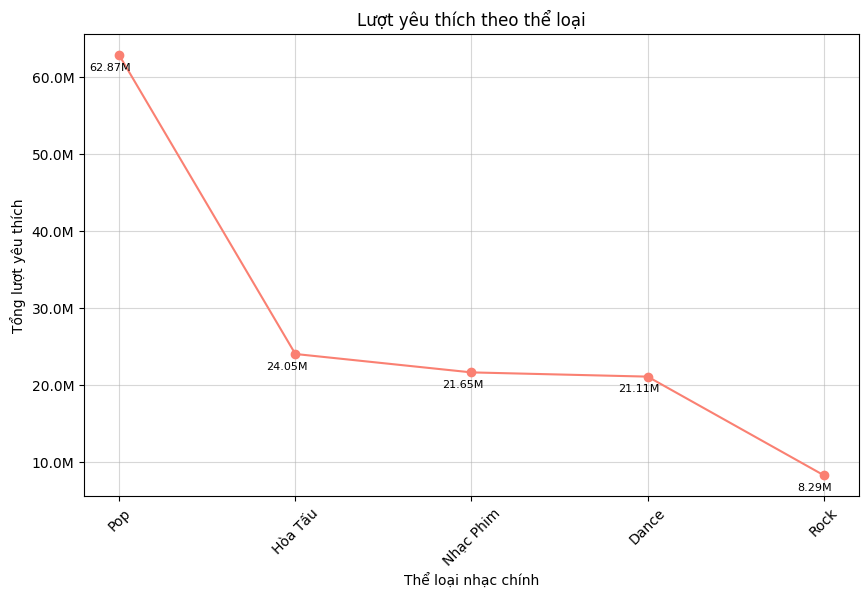

In [76]:
plt.figure(figsize=(10, 6))

plt.plot(top_5_theloai_luotyeuthich['Thể loại chính'], top_5_theloai_luotyeuthich['Tổng lượt yêu thích'], marker='o', color='salmon')

plt.title('Lượt yêu thích theo thể loại')

plt.xticks(rotation=45)
ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(tick*1e-6):.1f}M' for tick in ticks])

for i, value in enumerate(top_5_theloai_luotyeuthich['Tổng lượt yêu thích']):
    plt.text(i - 0.05, value - 1e6, f'{value*1e-6:.2f}M', ha='center', va='top', fontsize=8, color='black')

plt.xlabel('Thể loại nhạc chính')
plt.ylabel('Tổng lượt yêu thích')

plt.grid(True, alpha=0.5)

plt.show()


Một số insight được rút ra từ 2 biểu đồ đường trên:
- Biểu đồ đường của lượt nghe và lượt yêu thích đối với Top 5 thể loại phổ biến nhất có hình dạng tương tự nhau, thể hiện xu hướng giống nhau đối với từng thể loại ở lượt nghe và lượt yêu thích.
- Nhạc Pop vẫn là thể loại nhạc có số lượng lượt nghe và lượt yêu thích nổi bật hơn hẳn so với các thể loại nhạc khác, 4019.14 triệu lượt nghe và 62.87 triệu lượt yêu thích.
- Hòa Tấu, Nhạc Phim, và Dance có tổng giá trị ở cả lượt nghe và lượt yêu thích không có sự trên lệch quá nổi bật.
- Tuy nhiên, so với 3 thể loại đó thì nhạc Rock lại ít hơn 3 thể loại gần 3 lần ở cả tổng số lượt nghe và lượt yêu thích.

$\Rightarrow$ **Kết luận chung:**
- Tuy Hòa Tấu là thể loại nhạc có nhiều số lượng bài hát hơn hẳn Pop, nhưng nhạc Pop lại có tổng số lượng lượt nghe và lượt yêu thích hơn hẳn. Chắc hẳn, nhiều người dùng hiện này là người trẻ thích ưa chuộng những thể loại đương đại và người trẻ tuổi thường rành hơn về việc sử dụng công nghệ để thể hiện sự yêu thích của mình đối với bài hát ưa thích thông qua việc nghe nhạc trên nền tảng Zing MP3 hay ấn thả nút yêu thích cho bài hát đó. Chính vì vậy, tổng số lượng ở lượt nghe và lượt yêu thích lại nổi bật hơn hẳn so với các thể loại còn lại.
- Nhạc Dance có số lượng bài hát ít hơn khoảng gần 150 bài hát, lại có tổng lượt nghe và lượt yêu thích tương đương với nhạc Hòa Tấu. Ta có thể hiểu, tuy Hòa Tấu được khá nhiều nghệ sĩ ưa chuộng và trình bày, song, người dùng, người nghe lại không quá ưa thích ở thể loại này như nhạc Pop, Dnace, Phim. Vì 3 thể loại này khá gắn liền với cuộc sống thường ngày, các nền tảng mạng xã hội của họ, làm cho họ có thể bỗng trở nên ưa chuộng  và thích nghe, hoặc đơn giản để không lạc hậu, khác biệt so với phần lớn người khác.
- Rock tuy không phổ biến bằng những dòng nhạc khác nhưng cũng khá phổ biến vì theo Tiến sĩ Genevieve Dingle: "Nhạc rock có khả năng điều hòa tâm trạng, đặc biệt là những xúc cảm tiêu cực như nỗi buồn, sự giận dữ, thậm chí, nó còn giúp lên tâm trạng, làm nảy sinh những tình cảm tích cực sau khi người nghe được thư giãn với những bài hát rock mà họ yêu thích" [Trích](https://dantri.com.vn/van-hoa/nghe-nhac-rock-gam-gao-khien-ban-tinh-tam-hon-20160417172349873.htm#:~:text=Ti%E1%BA%BFn%20s%C4%A9%20Genevieve%20Dingle%20chia,rock%20m%C3%A0%20h%E1%BB%8D%20y%C3%AAu%20th%C3%ADch%E2%80%9D.)

---

### **Câu 3: Ở mỗi quốc gia, thể loại nào là phổ biến nhất?**

Đầu tiên chúng ta coi lại tất cả các thể loại

In [77]:
df_cleaned['Thể loại chính'].unique()

array(['Pop', 'Dance', 'Khác', 'Nhạc Phim', 'EDM', 'R&B', 'Hòa Tấu',
       'Blues', 'Rock', 'Nhạc Trịnh', 'Cải Lương', 'Nhạc Thiếu Nhi',
       'Nhạc Cách Mạng', 'Country', 'Jazz'], dtype=object)

In [ ]:
df_country = df_cleaned.groupby(['Quốc gia', 'Thể loại chính']).size().reset_index(name='Số bài hát')


df_country = df_country.sort_values(by=['Quốc gia', 'Số bài hát'], ascending=[True, False])


print(df_country)


    Quốc gia  Thể loại chính  Số bài hát
1   Hàn Quốc            Khác         144
2   Hàn Quốc       Nhạc Phim         100
3   Hàn Quốc             Pop          35
0   Hàn Quốc         Hòa Tấu           7
6   Nhật Bản             Pop          45
4   Nhật Bản            Khác          26
5   Nhật Bản       Nhạc Phim          20
7   Nhật Bản             R&B           5
8   Nhật Bản            Rock           4
13  Việt Nam            Khác         387
15  Việt Nam       Nhạc Phim         170
18  Việt Nam             Pop         161
12  Việt Nam         Hòa Tấu         129
10  Việt Nam           Dance         101
9   Việt Nam       Cải Lương         100
16  Việt Nam  Nhạc Thiếu Nhi         100
11  Việt Nam             EDM          97
17  Việt Nam      Nhạc Trịnh          97
20  Việt Nam            Rock          94
14  Việt Nam  Nhạc Cách Mạng          80
19  Việt Nam             R&B           2
26     Âu Mỹ            Khác         463
24     Âu Mỹ         Hòa Tấu         270
23     Âu Mỹ    

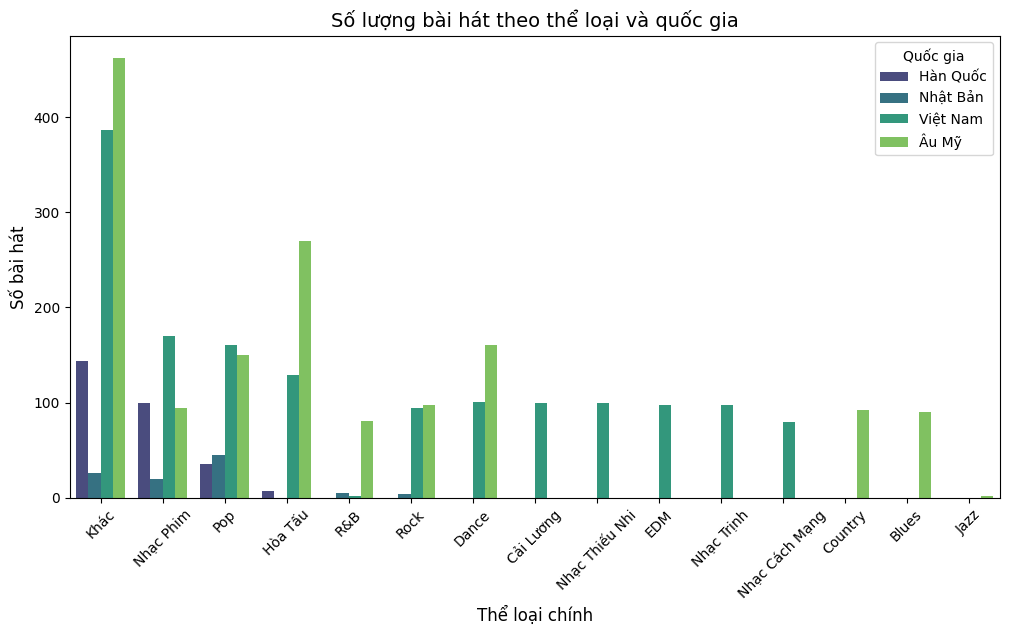

In [ ]:


plt.figure(figsize=(12, 6))

# Vẽ biểu đồ cột
sns.barplot(data=df_country, x="Thể loại chính", y="Số bài hát", hue="Quốc gia", palette="viridis")

# Thiết lập tiêu đề và nhãn
plt.title("Số lượng bài hát theo thể loại và quốc gia", fontsize=14)
plt.xlabel("Thể loại chính", fontsize=12)
plt.ylabel("Số bài hát", fontsize=12)
plt.xticks(rotation=45)


plt.legend(title="Quốc gia")
plt.show()


Có vẻ với biểu đồ này thì ta sẽ khá khó quan sát từng quốc gia nên ta sẽ tách riêng ra. Mỗi quốc gia sẽ ứng với 1 biểu đồ.

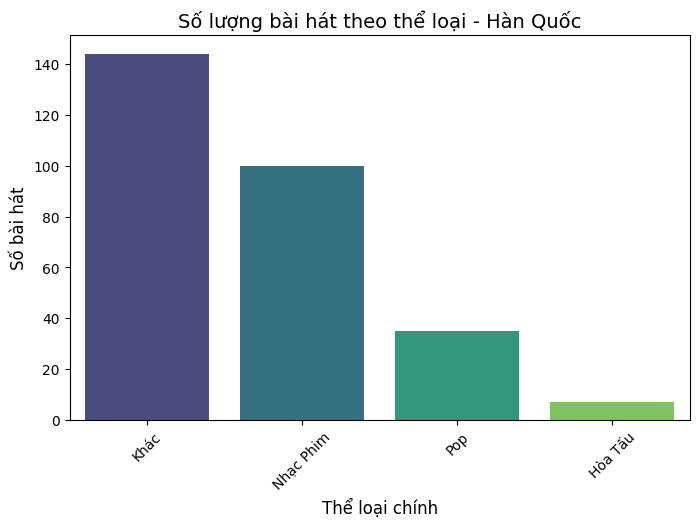

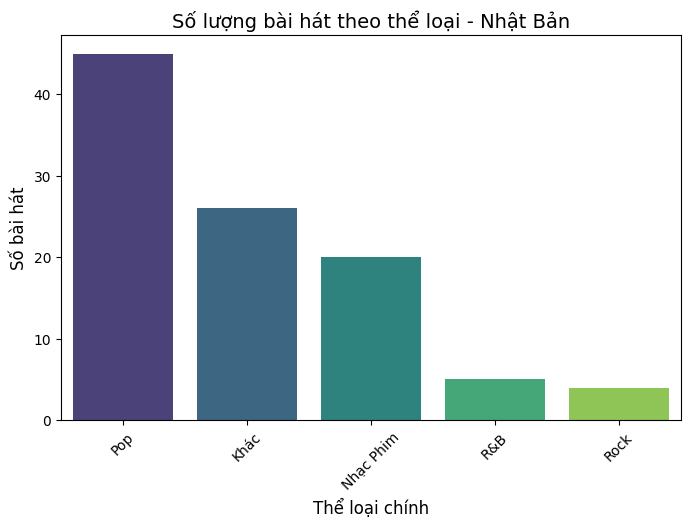

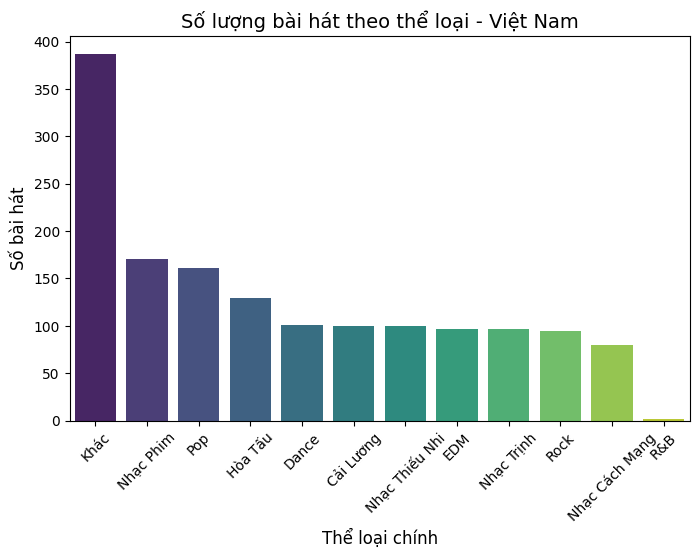

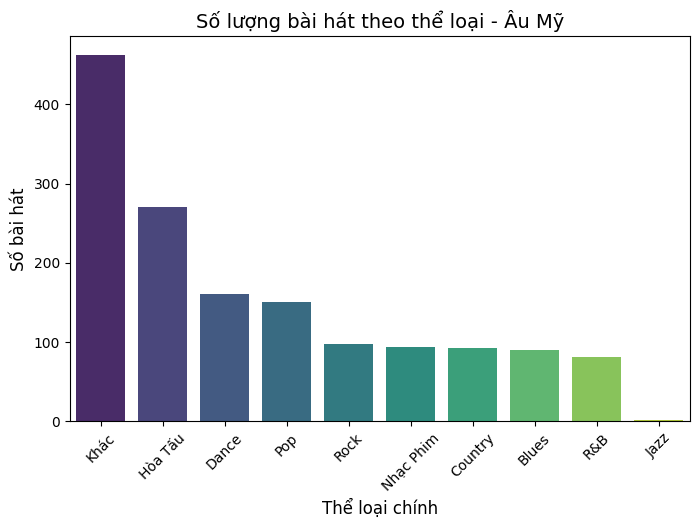

In [ ]:



countries = df_country["Quốc gia"].unique()

# Vẽ từng quốc gia riêng biệt
for country in countries:
    df_temp = df_country[(df_country["Quốc gia"] == country)]  # Lọc dữ liệu theo quốc gia

    # Tạo figure mới cho từng quốc gia
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_temp, x="Thể loại chính", y="Số bài hát", palette="viridis")

    # Thêm tiêu đề và nhãn
    plt.title(f"Số lượng bài hát theo thể loại - {country}", fontsize=14)
    plt.xlabel("Thể loại chính", fontsize=12)
    plt.ylabel("Số bài hát", fontsize=12)
    plt.xticks(rotation=45)

    
    plt.show()


Ở đây còn dính đến thể loại Khác(không rõ) nên ta sẽ không sử dụng thể loại đó

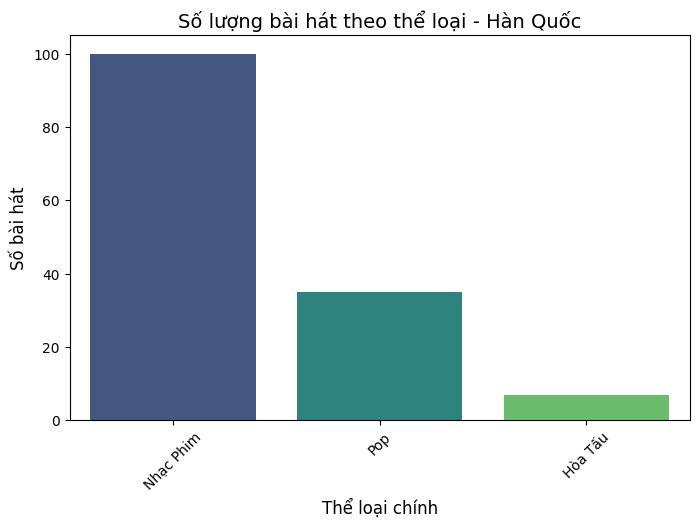

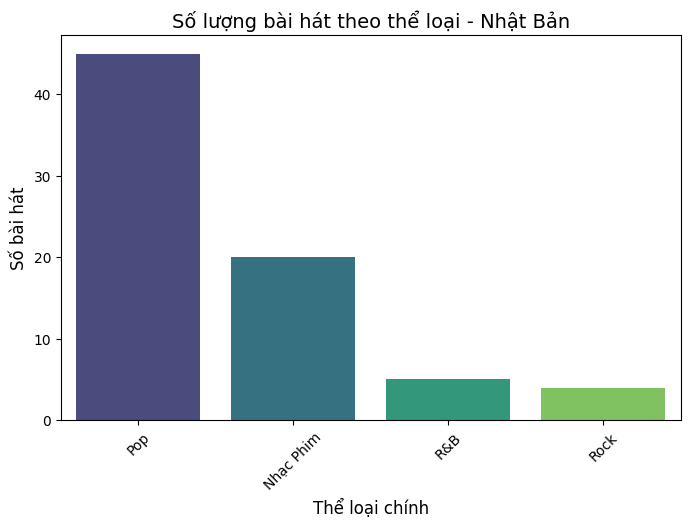

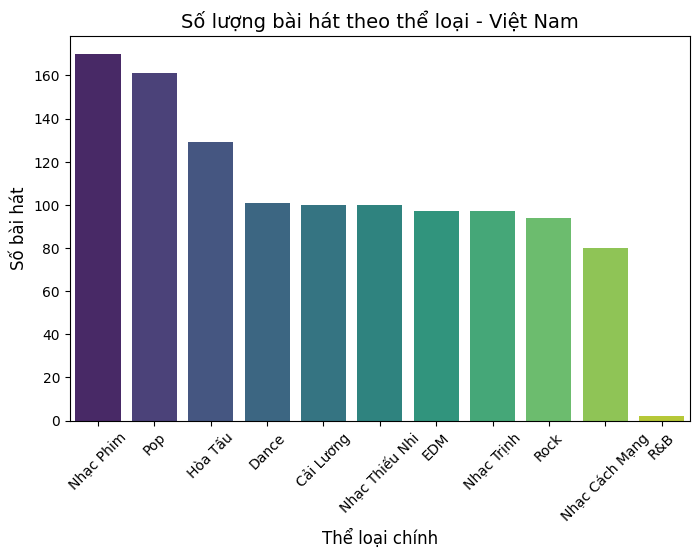

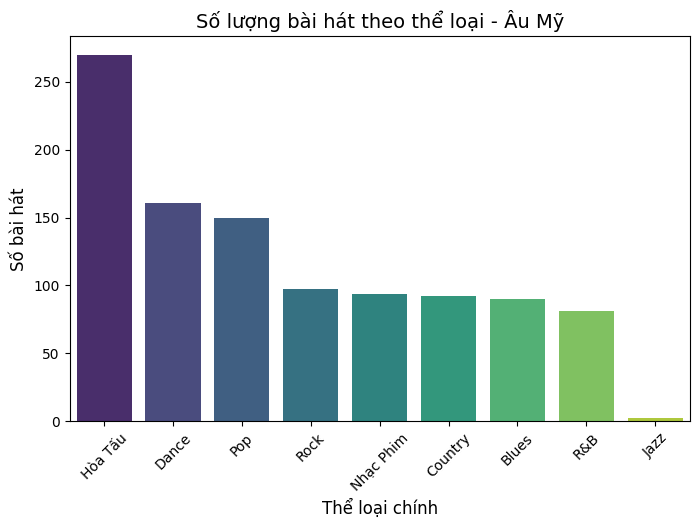

In [ ]:

# Lấy danh sách các quốc gia duy nhất
countries = df_country["Quốc gia"].unique()

# Vẽ từng quốc gia riêng biệt
for country in countries:
    df_temp = df_country[(df_country["Quốc gia"] == country) & (df_country['Thể loại chính'] != 'Khác')]  # Lọc dữ liệu theo quốc gia

    # Tạo figure mới cho từng quốc gia
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_temp, x="Thể loại chính", y="Số bài hát", palette="viridis")

    # Thêm tiêu đề và nhãn
    plt.title(f"Số lượng bài hát theo thể loại - {country}", fontsize=14)
    plt.xlabel("Thể loại chính", fontsize=12)
    plt.ylabel("Số bài hát", fontsize=12)
    plt.xticks(rotation=45)

    
    plt.show()

Theo như các biểu đồ chúng ta có thể thấy rõ được sự phân chia các thể loại ở mỗi quốc gia.
1. Hàn Quốc:
- Thể loại Nhạc Phim chiếm ưu thế: Đây là thể loại có số lượng bài hát nhiều nhất, khoảng 100 bài, cao hơn hẳn so với các thể loại khác.
- Thể loại Pop đứng thứ hai: Có số lượng bài hát ít hơn đáng kể so với Nhạc Phim, khoảng hơn 30 bài.
- Thể loại Hòa Tấu có số lượng thấp nhất: Chỉ có dưới 10 bài, thấp hơn rất nhiều so với hai thể loại còn lại.
- Sự chênh lệch lớn giữa các thể loại: Nhạc Phim có số lượng bài hát cao gấp nhiều lần so với Pop và Hòa Tấu, cho thấy sự phổ biến áp đảo của thể loại này trong danh sách.
2. Nhật Bản:
- Pop là thể loại phổ biến nhất: Với số lượng bài hát vượt trội, khoảng 45 bài, Pop là thể loại có nhiều bài hát nhất trong danh sách.
- Nhạc Phim đứng thứ hai: Có khoảng 20 bài hát, chỉ bằng một nửa so với Pop.
- R&B và Rock có số lượng ít: Hai thể loại này có số lượng bài hát tương đương nhau và thấp nhất trong danh sách, khoảng dưới 10 bài.
Chênh lệch đáng kể giữa các thể loại: Pop chiếm áp đảo, trong khi các thể loại khác có sự phân bố ít hơn nhiều, đặc biệt là R&B và Rock.
3. Việt Nam:
- Nhạc Phim và Pop có số lượng bài hát nhiều nhất: Nhạc Phim chiếm vị trí cao nhất với hơn 160 bài, theo sát là Pop với số lượng tương đương.
- Hòa Tấu có số lượng đáng kể: Đứng thứ ba với khoảng 130 bài hát, cho thấy sự phổ biến của thể loại này.
- Nhóm thể loại có số lượng trung bình: Dance, Cải Lương, Nhạc Thiếu Nhi, EDM, Nhạc Trịnh, và Rock có số lượng bài hát tương đương nhau, dao động quanh 100 bài.
- Nhạc Cách Mạng và R&B có số lượng ít nhất: Nhạc Cách Mạng có số bài hát dưới 90, trong khi R&B có số lượng rất nhỏ, gần như không đáng kể.
4. Âu Mỹ:
- Hòa Tấu áp đảo các thể loại khác: Đây là thể loại có số lượng bài hát nhiều nhất, vượt xa các thể loại khác với hơn 250 bài hát.
- Dance và Pop phổ biến: Dance có số lượng khoảng 160 bài, trong khi Pop có khoảng 150 bài, cho thấy mức độ phổ biến cao của hai thể loại này.
- Nhóm thể loại trung bình: Rock, Nhạc Phim, Country, và Blues có số lượng tương đương nhau, dao động quanh 100 bài hát.
- R&B có số lượng thấp hơn nhóm trung bình: Mặc dù phổ biến trên thị trường, nhưng số lượng bài hát thuộc thể loại này trong biểu đồ thấp hơn các thể loại trung bình, khoảng 80 bài.
- Jazz có số lượng bài hát thấp nhất: Thể loại này có số lượng rất nhỏ, gần như không đáng kể so với các thể loại khác.

$\Rightarrow$ **Kết luận chung:**

Ở Việt Nam và Âu Mỹ, sự phân hóa về thể loại âm nhạc rõ rệt hơn so với Nhật Bản. Trong khi Nhật Bản có số lượng bài hát tập trung chủ yếu vào một số ít thể loại chính như **Pop** và **Nhạc Phim**, thì ở Việt Nam và Âu Mỹ, số lượng bài hát được phân bổ đều hơn giữa nhiều thể loại khác nhau.

Cụ thể, tại **Việt Nam**, các thể loại như **Nhạc Phim, Pop, Hòa Tấu, Dance, Cải Lương, Nhạc Thiếu Nhi, EDM, Nhạc Trịnh, Rock, Nhạc Cách Mạng** đều có số lượng đáng kể, cho thấy sự đa dạng trong xu hướng nghe nhạc và thị hiếu âm nhạc của công chúng. Điều này phản ánh nền âm nhạc phong phú với sự kết hợp giữa các thể loại hiện đại như **EDM, Dance** và những dòng nhạc truyền thống như **Cải Lương, Nhạc Trịnh**.

Tương tự, tại **Âu Mỹ**, mặc dù thể loại **Hòa Tấu** có số lượng áp đảo, các thể loại như **Dance, Pop, Rock, Nhạc Phim, Country, Blues, R&B** cũng có sự hiện diện mạnh mẽ. Điều này cho thấy nền âm nhạc Âu Mỹ mang tính đa dạng, phản ánh sự phát triển của nhiều dòng nhạc khác nhau và sự tồn tại song song của các thể loại cổ điển như **Jazz, Blues** với những dòng nhạc phổ biến như **Pop, Dance**.

Ngược lại, tại **Nhật Bản**, số lượng bài hát lại tập trung chủ yếu vào một số thể loại chính, đặc biệt là **Pop**, chiếm phần lớn tổng số bài hát, trong khi các thể loại khác như **Nhạc Phim, R&B, Rock** có số lượng ít hơn đáng kể. Điều này có thể phản ánh xu hướng nghe nhạc tại Nhật Bản có sự tập trung cao vào một số dòng nhạc phổ biến, thay vì phân tán ra nhiều thể loại khác nhau như ở Việt Nam hay Âu Mỹ.

Nhìn chung, dữ liệu cho thấy **Việt Nam và Âu Mỹ có sự đa dạng thể loại hơn, trong khi Nhật Bản có xu hướng tập trung vào một số ít thể loại chủ đạo**. Điều này có thể xuất phát từ sự khác biệt trong **thị hiếu âm nhạc, văn hóa và sự phát triển của ngành công nghiệp âm nhạc** tại từng khu vực.

Giờ chúng ta sẽ tìm ra đâu là thể loại chính mà phổ biến ở các quốc gia nhất

In [ ]:

df_country = df_country[df_country["Thể loại chính"] != "Khác"]

# Tìm số bài hát cao nhất cho từng quốc gia
max_songs_per_country = df_country.groupby("Quốc gia")["Số bài hát"].max().reset_index()
max_songs_per_country.columns = ["Quốc gia", "Max Bài Hát"]

# Kết hợp để lấy các thể loại có số bài hát bằng giá trị max
df_result = df_country.merge(max_songs_per_country, on="Quốc gia")
df_result = df_result[df_result["Số bài hát"] == df_result["Max Bài Hát"]].drop(columns=["Max Bài Hát"])

# Hiển thị kết quả
print(df_result)



    Quốc gia Thể loại chính  Số bài hát
0   Hàn Quốc      Nhạc Phim         100
3   Nhật Bản            Pop          45
7   Việt Nam      Nhạc Phim         170
18     Âu Mỹ        Hòa Tấu         270


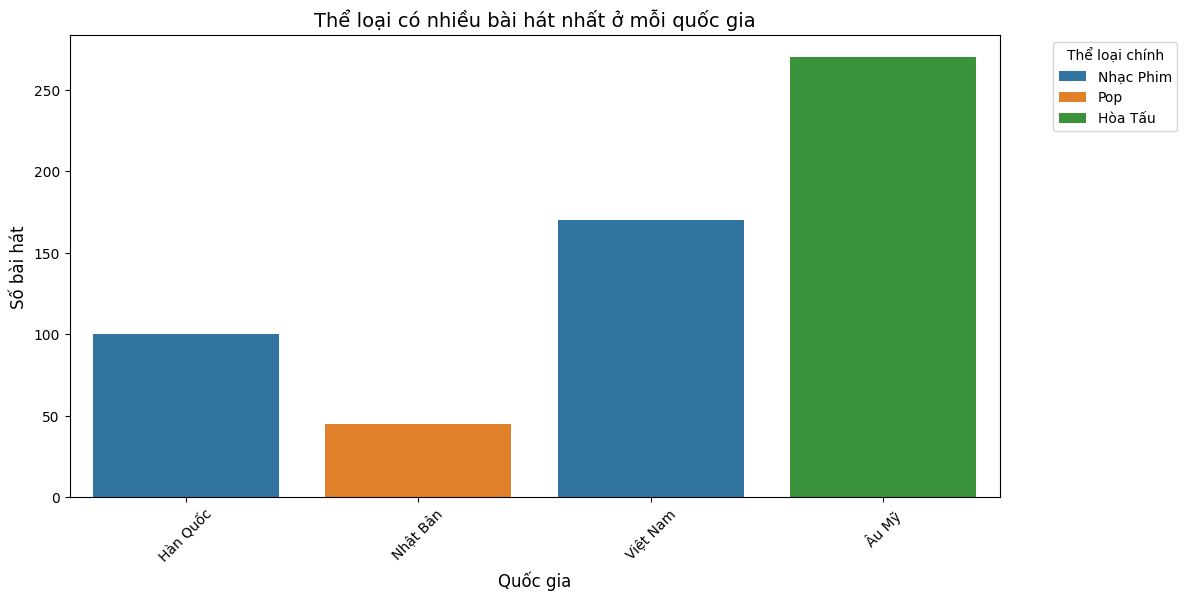

In [ ]:

plt.figure(figsize=(12, 6))
sns.barplot(data=df_result, x="Quốc gia", y="Số bài hát", hue="Thể loại chính", palette="tab10")

# Thêm tiêu đề và nhãn
plt.title("Thể loại có nhiều bài hát nhất ở mỗi quốc gia", fontsize=14)
plt.xlabel("Quốc gia", fontsize=12)
plt.ylabel("Số bài hát", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Thể loại chính", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


$\Rightarrow$ **Nhận xét**:   
- Hàn Quốc và Việt Nam có điểm chung khi thể loại có số lượng bài hát cao nhất đều là Nhạc Phim, với số lượng bài hát tại Việt Nam nhiều hơn so với Hàn Quốc. Điều này phản ánh sự phổ biến của nhạc phim trong nền công nghiệp giải trí tại cả hai quốc gia, khi âm nhạc gắn liền với các bộ phim truyền hình và điện ảnh.
- Nhật Bản có thể loại chiếm ưu thế là Pop, nhưng số lượng bài hát thuộc thể loại này thấp hơn đáng kể so với các thể loại đứng đầu ở các quốc gia khác. Điều này có thể cho thấy mức độ phân tán trong thể loại nhạc của Nhật Bản hoặc sự tập trung vào một số ít dòng nhạc nhất định.
- Âu Mỹ có số lượng bài hát thuộc thể loại Hòa Tấu cao nhất, vượt trội so với các thể loại đứng đầu của các quốc gia khác. Điều này có thể phản ánh sự phát triển mạnh mẽ của dòng nhạc không lời, cổ điển, và nhạc cụ trong nền âm nhạc phương Tây

                 Loại  Lượt yêu thích     Lượt nghe
0  Nhạc Phim Việt Nam    45556.764706  2.939809e+06
1  Nhạc Phim Hàn Quốc    64995.000000  4.246475e+06
2        Pop Nhật Bản    63551.377778  4.152125e+06
3       Hoà tấu Âu Mỹ    59846.640741  3.908010e+06


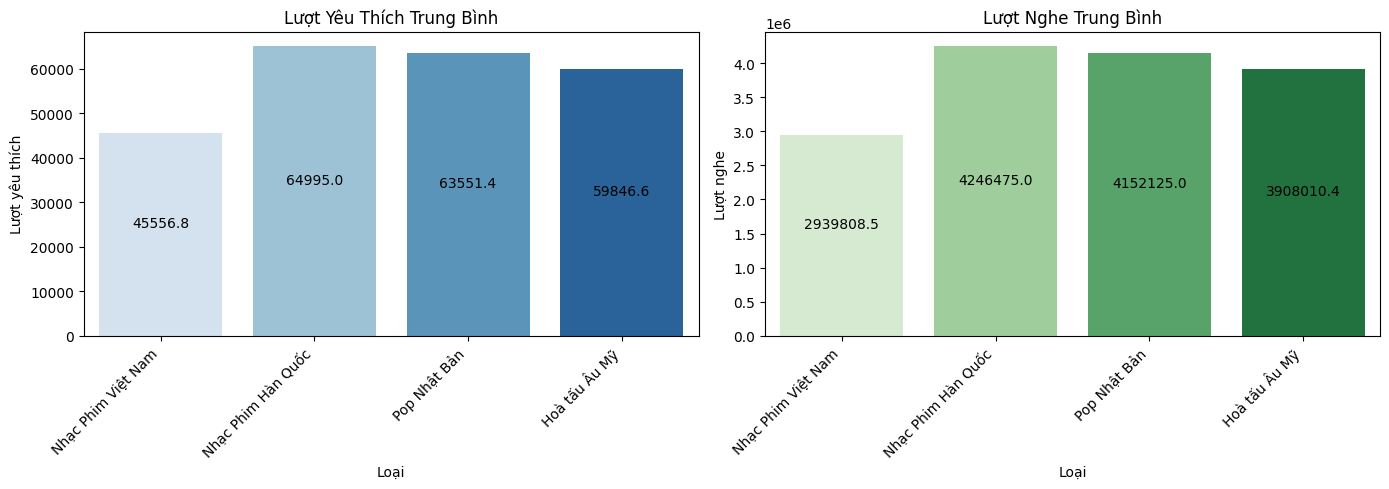

In [151]:

nhac_phim_vn = df_cleaned[(df_cleaned['Thể loại chính'] == 'Nhạc Phim') & (df_cleaned['Quốc gia'] == 'Việt Nam')]
nhac_phim_kr = df_cleaned[(df_cleaned['Thể loại chính'] == 'Nhạc Phim') & (df_cleaned['Quốc gia'] == 'Hàn Quốc')]
pop_jp = df_cleaned[(df_cleaned['Thể loại chính'] == 'Pop') & (df_cleaned['Quốc gia'] == 'Nhật Bản')]
# print(df_cleaned['Thể loại chính'].unique())
# print(df_cleaned['Quốc gia'].unique())

hoa_tau_us = df_cleaned[(df_cleaned['Thể loại chính'] == 'Hòa Tấu') & (df_cleaned['Quốc gia'] == 'Âu Mỹ')]

# print(df_cleasned[(df_cleaned['Quốc gia'] == 'Âu Mỹ')]['Thể loại chính']) 

# print(hoa_tau_us)

result = {
    'Nhạc Phim Việt Nam': {
        'Lượt yêu thích': nhac_phim_vn['Lượt yêu thích'].mean(),
        'Lượt nghe': nhac_phim_vn['Lượt nghe'].mean()
    },
    'Nhạc Phim Hàn Quốc': {
        'Lượt yêu thích': nhac_phim_kr['Lượt yêu thích'].mean(),
        'Lượt nghe': nhac_phim_kr['Lượt nghe'].mean()
    },
    'Pop Nhật Bản': {
        'Lượt yêu thích': pop_jp['Lượt yêu thích'].mean(),
        'Lượt nghe': pop_jp['Lượt nghe'].mean()
    },
    'Hoà tấu Âu Mỹ': {
        'Lượt yêu thích': hoa_tau_us['Lượt yêu thích'].fillna(value=0).mean(),
        'Lượt nghe': hoa_tau_us['Lượt nghe'].fillna(value=0).mean()
    }
}




df_result = pd.DataFrame(result).T.reset_index()
df_result.rename(columns={'index': 'Loại'}, inplace=True)
print(df_result)



# Vẽ biểu đồ
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ cột cho lượt yêu thích trung bình
sns.barplot(data=df_result, x='Loại', y='Lượt yêu thích', ax=ax[0], palette='Blues')
ax[0].set_title('Lượt Yêu Thích Trung Bình')
ax[0].set_xticklabels(df_result['Loại'], rotation=45, ha='right')

# Hiển thị giá trị trên cột lượt yêu thích
for p in ax[0].containers:
    ax[0].bar_label(p, fmt='%.1f', label_type='center', padding=8, fontsize=10)

# Biểu đồ cột cho lượt nghe trung bình
sns.barplot(data=df_result, x='Loại', y='Lượt nghe', ax=ax[1], palette='Greens')
ax[1].set_title('Lượt Nghe Trung Bình')
ax[1].set_xticklabels(df_result['Loại'], rotation=45, ha='right')

# Hiển thị giá trị trên cột lượt nghe
for p in ax[1].containers:
    ax[1].bar_label(p, fmt='%.1f', label_type='center', padding=8, fontsize=10)

plt.tight_layout()
plt.show()





#### 1. Lượt Yêu Thích Trung Bình:
- **Nhạc Phim Hàn Quốc** có số lượt yêu thích trung bình cao nhất (~64,995), cho thấy dòng nhạc này được khán giả yêu thích và đánh giá cao.
- **Pop Nhật Bản** có mức yêu thích gần tương đương với Nhạc Phim Hàn Quốc (~63,551.4), cho thấy nhạc Pop ở Nhật có sự quan tâm lớn từ khán giả.
- **Hòa Tấu Âu Mỹ** cũng có số lượt yêu thích cao (~59,846.6), chứng tỏ dòng nhạc này có lượng người hâm mộ đáng kể.
- **Nhạc Phim Việt Nam** có lượt yêu thích thấp nhất (~45,556.8), cho thấy dù thể loại này phổ biến ở Việt Nam, nhưng không được đánh giá cao bằng các thể loại khác.

#### 2. Lượt Nghe Trung Bình:
- **Nhạc Phim Hàn Quốc** tiếp tục dẫn đầu về số lượt nghe trung bình (~4,246,475), cho thấy dòng nhạc này không chỉ được yêu thích mà còn được nghe rất nhiều.
- **Pop Nhật Bản** cũng có số lượt nghe cao (~4,152,125), cho thấy sự quan tâm lớn đối với thể loại này.
- **Hòa Tấu Âu Mỹ** có số lượt nghe trung bình (~3,908,010.4), vẫn ở mức cao nhưng thấp hơn so với hai thể loại trên.
- **Nhạc Phim Việt Nam** có số lượt nghe thấp nhất (~2,939,808.5), phù hợp với số lượt yêu thích thấp nhất của thể loại này.

### Tổng kết:
- **Nhạc Phim Hàn Quốc** có mức độ phổ biến cao nhất cả về lượt yêu thích lẫn lượt nghe.
- **Pop Nhật Bản** có sự cân bằng giữa hai chỉ số, cho thấy dòng nhạc này có lượng người hâm mộ ổn định.
- **Hòa Tấu Âu Mỹ** vẫn được yêu thích nhưng có xu hướng nghe ít hơn so với Nhạc Phim Hàn Quốc và Pop Nhật Bản.
- **Nhạc Phim Việt Nam** dù phổ biến nhưng có lượt yêu thích và nghe trung bình thấp nhất trong 4 thể loại.

=> **Nhạc Phim Hàn Quốc và Pop Nhật Bản có sức ảnh hưởng lớn nhất, trong khi Nhạc Phim Việt Nam có sự quan tâm thấp hơn từ công chúng.**

---

### **Câu 4: Hãy cùng nhau xem xu hướng nhạc ở Việt Nam như thế nào?**


Đầu tiên chúng ta sẽ coi thử xem số lượng bài hát thuộc Việt Nam so với các nước khác

Quốc gia
Việt Nam    1518
Âu Mỹ       1500
Hàn Quốc     286
Nhật Bản     100
Name: count, dtype: int64


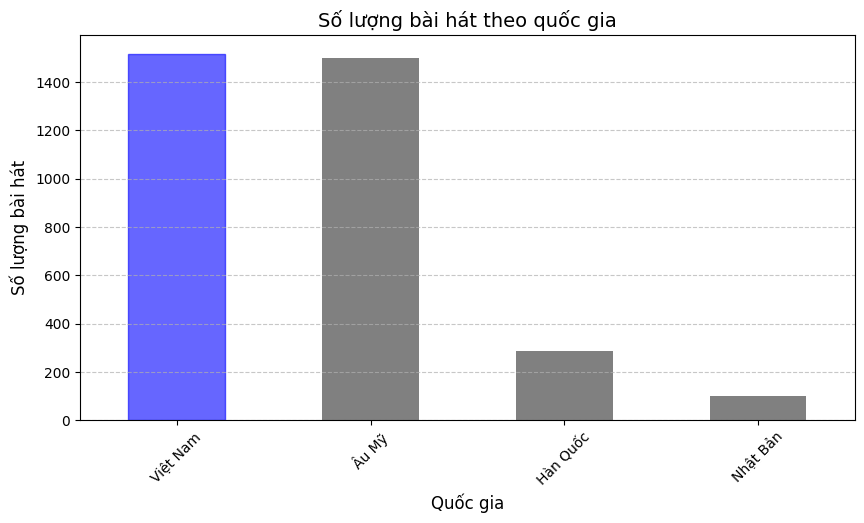

In [160]:


# Đếm số lượng bài hát theo quốc gia
song_counts = df_cleaned['Quốc gia'].value_counts()
print(song_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 5))
bars = song_counts.plot(kind='bar', color='gray')

# Chỉnh màu và alpha cho cột "Việt Nam"
for bar, country in zip(bars.patches, song_counts.index):
    if country == 'Việt Nam':
        bar.set_color('blue')
        bar.set_alpha(0.6)  # Thêm độ trong suốt

# Tùy chỉnh biểu đồ
plt.title("Số lượng bài hát theo quốc gia", fontsize=14)
plt.xlabel("Quốc gia", fontsize=12)
plt.ylabel("Số lượng bài hát", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()




1. **Việt Nam và Âu Mỹ có số lượng bài hát cao nhất**:  
   - Việt Nam và Âu Mỹ có số lượng bài hát gần bằng nhau, cao hơn hẳn so với các quốc gia khác.  
   - Thanh màu đỏ đại diện cho Việt Nam nổi bật hơn, có thể để nhấn mạnh dữ liệu này.  

2. **Hàn Quốc và Nhật Bản có số lượng bài hát ít hơn đáng kể**:  
   - Hàn Quốc có số lượng bài hát cao hơn Nhật Bản nhưng vẫn thấp hơn nhiều so với Việt Nam và Âu Mỹ.  
   - Nhật Bản có số lượng bài hát thấp nhất trong danh sách.  

3. **Chênh lệch lớn về số lượng bài hát giữa các khu vực**:  
   - Số lượng bài hát từ Việt Nam và Âu Mỹ áp đảo so với Hàn Quốc và Nhật Bản.  
   - Điều này có thể do sự phát triển của nền âm nhạc ở mỗi quốc gia hoặc đặc điểm của dữ liệu thu thập.  

### Kết luận:
- Nhạc Việt Nam và Âu Mỹ có số lượng bài hát lớn, cho thấy sự phong phú và đa dạng trong danh sách bài hát được khảo sát.  
- Nhạc Hàn Quốc và Nhật Bản có số lượng ít hơn, có thể do giới hạn trong danh sách hoặc sự tập trung vào các dòng nhạc phổ biến hơn.

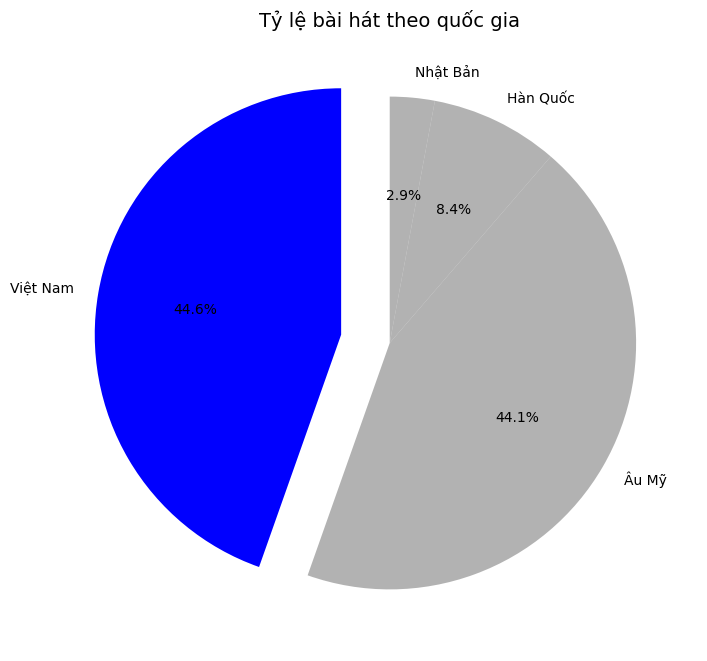

In [165]:

plt.figure(figsize=(8, 8))
song_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['blue' if country == 'Việt Nam' else '#80808099' for country in song_counts.index],  # Màu có alpha
    explode=[0.2 if country == 'Việt Nam' else 0 for country in song_counts.index]  # Tách Việt Nam ra
)
plt.ylabel('')  # Ẩn nhãn trục y
plt.title("Tỷ lệ bài hát theo quốc gia", fontsize=14)
plt.show()




### Nhận xét biểu đồ "Tỷ lệ bài hát theo quốc gia":

1. **Việt Nam và Âu Mỹ chiếm tỷ lệ lớn nhất**:  
   - Việt Nam chiếm **44.6%** tổng số bài hát, cao nhất trong danh sách.  
   - Âu Mỹ xếp ngay sau với **44.1%**, gần bằng Việt Nam.  
   - Hai khu vực này chiếm gần **89%** tổng số bài hát, cho thấy sự áp đảo về số lượng bài hát so với các khu vực khác.  

2. **Hàn Quốc và Nhật Bản có tỷ lệ thấp hơn**:  
   - Hàn Quốc chiếm **8.4%**, thấp hơn nhiều so với Việt Nam và Âu Mỹ.  
   - Nhật Bản có tỷ lệ thấp nhất với **2.9%**, cho thấy số lượng bài hát từ Nhật Bản trong danh sách là rất ít.  

3. **Chênh lệch lớn giữa các khu vực**:  
   - Nhạc Việt Nam và Âu Mỹ gần như chiếm toàn bộ danh sách, trong khi nhạc Hàn Quốc và Nhật Bản chỉ chiếm một phần nhỏ.  
   - Điều này có thể phản ánh sự phổ biến của nhạc Việt Nam và Âu Mỹ trong tập dữ liệu hoặc trong thực tế.  



Vậy ở Việt Nam thể loại nhạc nào đang dần trở nên xu hướng ?

In [ ]:

df_vietnam = df_cleaned[df_cleaned['Quốc gia'] == 'Việt Nam']

top_10_songs = df_vietnam.nlargest(10, 'Lượt nghe')


print(top_10_songs['Tên bài hát', 'Lượt nghe (dễ nhìn)'])


                 Tên bài hát Lượt nghe (dễ nhìn)  Lượt yêu thích
48                  Tòng Phu              190.0M       2800000.0
44             Sao Cũng Được              140.0M       2100000.0
69           Em Nên Dừng Lại              132.0M       2000000.0
1034  Ngày Mai Người Ta Lấy…              123.0M       1900000.0
16    Ngày Mai Người Ta Lấy…              123.0M       1900000.0
14           Cắt Đôi Nỗi Sầu              122.0M       1800000.0
73      Em Là Kẻ Đáng Thương              116.0M       1500000.0
57                Hoa Cỏ Lau              103.0M       1400000.0
66                  Ngoài 30               93.0M       1300000.0
91              Thuyền Quyên               92.0M       1300000.0


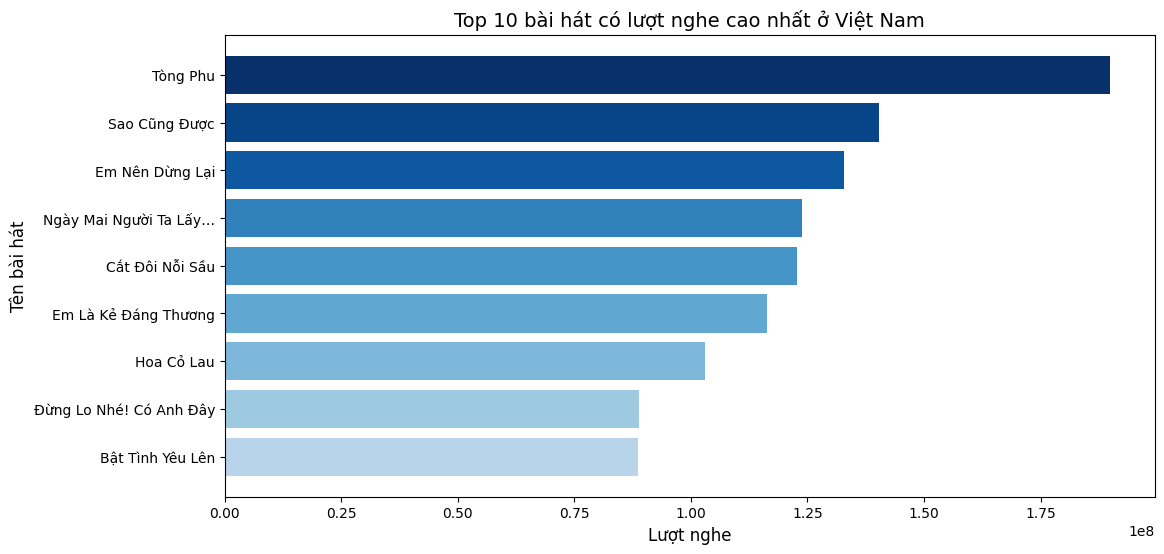

In [168]:


plt.figure(figsize=(12, 6))

# Tạo danh sách màu xanh giảm dần dựa trên thứ hạng
colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_10_songs)))  

plt.barh(top_10_songs['Tên bài hát'], top_10_songs['Lượt nghe'], color=colors)

# Tùy chỉnh trục và nhãn
plt.xlabel("Lượt nghe", fontsize=12)
plt.ylabel("Tên bài hát", fontsize=12)
plt.title("Top 10 bài hát có lượt nghe cao nhất ở Việt Nam", fontsize=14)
plt.gca().invert_yaxis()  # Đảo chiều để bài hát có lượt nghe cao nhất nằm trên cùng

plt.show()



**Nhận xét**

- Bài hát "Tòng Phu" có số lượt nghe cao nhất, bỏ xa các bài hát còn lại. Điều này cho thấy bài hát này có mức độ phổ biến rất lớn trong cộng đồng nghe nhạc.
- Khoảng cách giữa các bài hát: "Sao Cũng Được" và "Em Nên Dừng Lại" đứng ở vị trí thứ hai và ba nhưng có khoảng cách đáng kể so với "Tòng Phu".
Các bài hát còn lại có số lượt nghe khá tương đương nhau, nhưng vẫn có sự phân hóa giữa top đầu và cuối bảng.


Còn đối với lượt yêu thích thì những bài hát nào đang đứng top đầu

In [ ]:

top_10_songs = df_vietnam.nlargest(10, 'Lượt yêu thích')


print(top_10_songs[['Tên bài hát', 'Lượt yêu thích (dễ nhìn)']])

                  Tên bài hát Lượt yêu thích (dễ nhìn)
48                   Tòng Phu                     2.0M
44              Sao Cũng Được                     2.0M
69            Em Nên Dừng Lại                     2.0M
16     Ngày Mai Người Ta Lấy…                     1.0M
1034   Ngày Mai Người Ta Lấy…                     1.0M
14            Cắt Đôi Nỗi Sầu                     1.0M
73       Em Là Kẻ Đáng Thương                     1.0M
57                 Hoa Cỏ Lau                     1.0M
80    Đừng Lo Nhé! Có Anh Đây                     1.0M
47           Bật Tình Yêu Lên                     1.0M


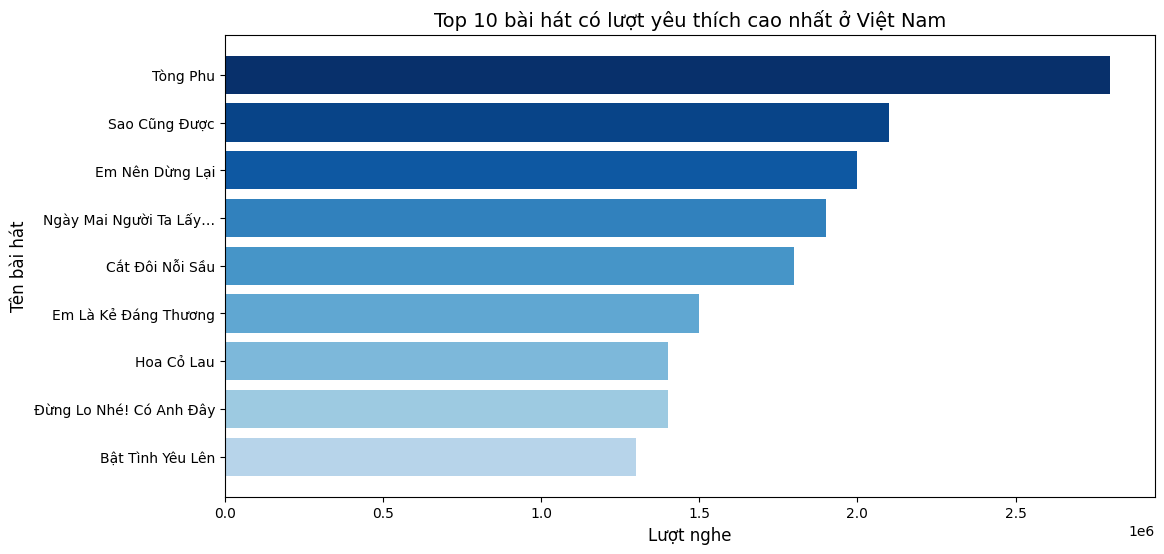

In [169]:
plt.figure(figsize=(12, 6))

# Tạo danh sách màu xanh giảm dần dựa trên thứ hạng
colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_10_songs)))  

plt.barh(top_10_songs['Tên bài hát'], top_10_songs['Lượt yêu thích'], color=colors)

# Tùy chỉnh trục và nhãn
plt.xlabel("Lượt nghe", fontsize=12)
plt.ylabel("Tên bài hát", fontsize=12)
plt.title("Top 10 bài hát có lượt yêu thích cao nhất ở Việt Nam", fontsize=14)
plt.gca().invert_yaxis()  # Đảo chiều để bài hát có lượt nghe cao nhất nằm trên cùng

plt.show()

### Nhận xét biểu đồ:

1. **"Tòng Phu" tiếp tục đứng đầu**:  
   - Bài hát "Tòng Phu" có lượt yêu thích cao nhất, cho thấy mức độ phổ biến không chỉ ở lượt nghe mà còn ở mức độ yêu thích của người nghe.  
   - Điều này phản ánh rằng bài hát này có sự lan tỏa mạnh mẽ và được khán giả đón nhận tích cực.  

2. **Sự tương đồng với biểu đồ lượt nghe**:  
   - Các bài hát đứng vị trí cao về lượt yêu thích cũng tương đồng với danh sách có lượt nghe cao nhất.  
   - Điều này cho thấy rằng những bài hát có nhiều lượt nghe thường cũng có tỷ lệ yêu thích cao.  

3. **Chênh lệch giữa các bài hát**:  
   - "Tòng Phu" có khoảng cách đáng kể về lượt yêu thích so với các bài hát xếp sau như "Sao Cũng Được" và "Em Nên Dừng Lại".  
   - Các bài hát xếp từ vị trí thứ 5 trở đi có mức độ yêu thích khá sát nhau, không có sự chênh lệch lớn.  



Có vẻ như danh sách top 10 bài hát trong cả hai biểu đồ (lượt nghe cao nhất và lượt yêu thích cao nhất) đều giống nhau, cho thấy rằng những ca khúc này không chỉ thu hút được một lượng lớn người nghe mà còn nhận được sự yêu thích đáng kể từ khán giả. Điều này phản ánh rằng các bài hát không chỉ phổ biến nhờ số lượt phát mà còn có chất lượng tốt, giai điệu hoặc nội dung đủ hấp dẫn để tạo sự gắn kết với người nghe, khiến họ chủ động bày tỏ sự yêu thích. Giờ chúng ta sẽ tiến hành phân tích để biết xu hướng là gì.

In [140]:
genre_counts = top_10_songs['Thể loại'].value_counts()
print(genre_counts)


Thể loại
V-Pop    10
Name: count, dtype: int64


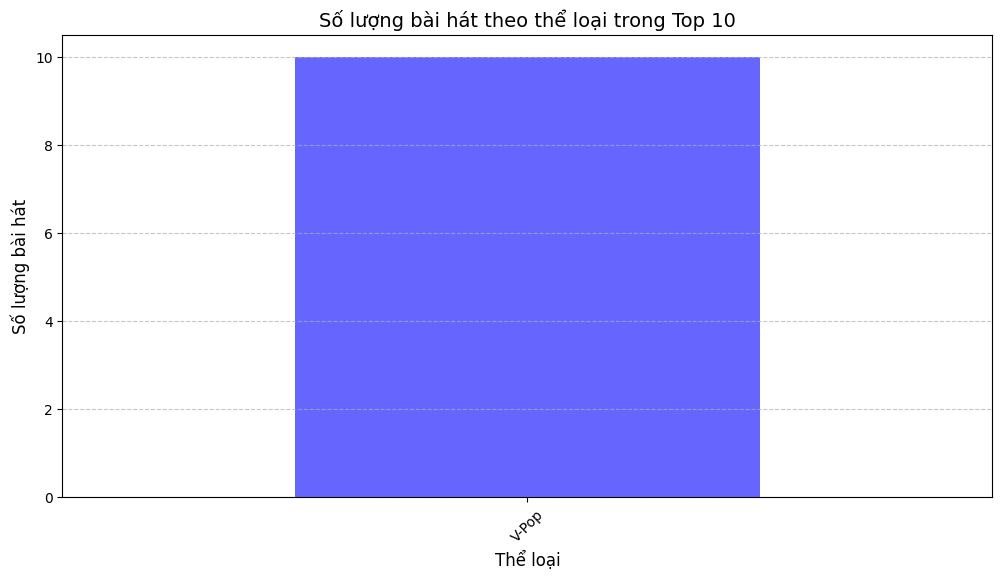

In [170]:


# Vẽ biểu đồ cột
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='blue', alpha=0.6)

# Tùy chỉnh biểu đồ
plt.xlabel("Thể loại", fontsize=12)
plt.ylabel("Số lượng bài hát", fontsize=12)
plt.title("Số lượng bài hát theo thể loại trong Top 10", fontsize=14)
plt.xticks(rotation=45)  # Xoay nhãn thể loại cho dễ đọc
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()


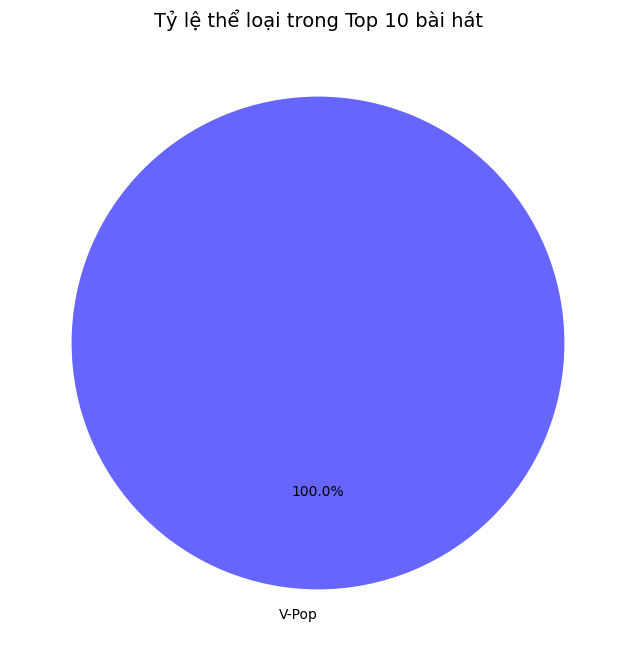

In [186]:



total_songs = genre_counts.sum()

# Lọc các thể loại chiếm hơn 10% tổng số bài hát
genre_filtered = genre_counts[genre_counts / total_songs > 0.1]

# Thêm 'Khác' nếu có các thể loại chiếm dưới 10%
other_songs = total_songs - genre_filtered.sum()
if other_songs > 0:
    genre_filtered["Khác"] = other_songs

# Tạo màu với alpha = 0.6
colors = [(0, 0, 1, 0.6)] * len(genre_filtered)

plt.figure(figsize=(8, 8))
genre_filtered.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors)

# Ẩn nhãn trục y
plt.ylabel('')
plt.title("Tỷ lệ thể loại trong Top 10 bài hát", fontsize=14)

# Hiển thị biểu đồ
plt.show()


$\Rightarrow$ **Kết luận:**
Chúng ta có thể dễ dàng nhận thấy rằng cả 10 bài hát đứng đầu trong danh sách đều thuộc thể loại V-Pop. Điều này cho thấy rằng nhạc V-Pop đang ngày càng phát triển mạnh mẽ và thu hút sự quan tâm lớn từ công chúng. Việc cả 10 ca khúc đều thuộc dòng nhạc này chứng tỏ V-Pop không chỉ chiếm ưu thế trên các nền tảng nghe nhạc trực tuyến mà còn đang dần trở thành xu hướng chủ đạo trong thị trường âm nhạc Việt Nam. Sự phổ biến rộng rãi của V-Pop có thể đến từ nhiều yếu tố như sự đổi mới trong phong cách âm nhạc, nội dung bài hát phù hợp với thị hiếu của khán giả trẻ, cũng như sự đầu tư kỹ lưỡng vào hình ảnh và chiến lược quảng bá. Với đà phát triển này, V-Pop hứa hẹn sẽ tiếp tục mở rộng phạm vi ảnh hưởng và có cơ hội vươn ra thị trường quốc tế trong tương lai.

## **NGUỒN THAM KHẢO**

1. [Danh sách album để lấy dữ liệu](https://zingmp3.vn/top100)
2. [Cách xác định locators - Java](https://anhtester.com/blog/selenium-java-bai-5-cach-xac-dinh-locators-cua-element-tren-website-b349.html)
3. [Selenium - Action chains in Python](https://www.geeksforgeeks.org/action-chains-in-selenium-python/)
4. [Cách đóng popup](https://www.reddit.com/r/learnpython/comments/12jp1kd/unable_to_locate_the_x_button_in_a_pop_up_message/?rdt=64842)
5. [Top 10 thể loại nhạc phổ biến hiện nay](https://antuan.vn/top-10-the-loai-nhac-pho-bien-hien-nay/) *(Cập nhật: 28/05/2024)*
6. [Adding value labels on a Matplotlib Bar Chart](https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/)
7. [ChatGPT](https://chat.openai.com/chat)

$$***$$